# Event Detection Via Social Media Data
----
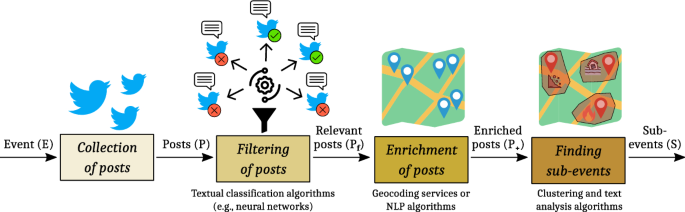

```
[Belcastro, L., Marozzo, F., Talia, D. et al. Using social media for sub-event detection during disasters. J Big Data 8, 79 (2021). https://doi.org/10.1186/s40537-021-00467-1]

```




## Table of Content

## Introduction

##Data Loading

In [ ]:
#@title Install NER Models
# !pip install -U arabert
# !pip install farasapy

In [ ]:
#@title Install Fast Text Model
# !pip install fasttext
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
!gunzip cc.ar.300.vec.gz


--2025-06-02 08:33:48--  https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.ar.300.vec.gz
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.226.210.25, 13.226.210.111, 13.226.210.78, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.226.210.25|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1272365870 (1.2G) [binary/octet-stream]
Saving to: ‘cc.ar.300.vec.gz.1’

cc.ar.300.vec.gz.1  100%[===================>]   1.18G  54.3MB/s    in 22s     

2025-06-02 08:34:10 (54.6 MB/s) - ‘cc.ar.300.vec.gz.1’ saved [1272365870/1272365870]

gzip: cc.ar.300.vec already exists; do you wish to overwrite (y or n)? y


In [ ]:
#@title Install Packages
!pip install transformers
!pip install arabic-reshaper
!pip install python-bidi
!pip install ar_wordcloud


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 292.9/292.9 kB 6.3 MB/s eta 0:00:00


In [ ]:
#@title Install Packages
# Install NLTK
!pip install nltk

# Import and download stopwords
import nltk
nltk.download('stopwords')

# Load Arabic stopwords
from nltk.corpus import stopwords
arabic_stopwords = stopwords.words('arabic')

# !pip install transformers
# !pip install stanza --quiet
# # !pip install --upgrade scipy

# !pip install gensim
# import stanza

# Download Arabic model once
# stanza.download('ar', verbose=False)

# Initialize pipeline for Arabic with NER
# nlp = stanza.Pipeline('ar', processors='tokenize,ner', use_gpu=True)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
#@title Fix Dependency Issue
# !pip install scipy==1.10.1
# !pip uninstall -y numpy gensim
# !pip install numpy==1.24.3 gensim==4.3.1
# Fix versions to ensure compatibility
!pip install --upgrade pip
!pip install scipy==1.10.1
!pip uninstall -y numpy gensim
!pip install numpy==1.24.3 gensim==4.3.1
!pip install tensorflow==2.13.0  # Stable with numpy 1.24



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 19.5 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 24.1.2
    Uninstalling pip-24.1.2:
      Successfully uninstalled pip-24.1.2
Found existing installation: numpy 1.24.3
Uninstalling numpy-1.24.3:
  Successfully uninstalled numpy-1.24.3
Found existing installation: gensim 4.3.1
Uninstalling gensim-4.3.1:
  Successfully uninstalled gensim-4.3.1
  Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
  Using cached gensim-4.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.4 kB)
Using cached numpy-1.24.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
Using cached gensim-4.3.1-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.6 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0/2 [numpy]

In [ ]:
#@title import packages
import numpy as np
import requests
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from math import sqrt

from bidi.algorithm import get_display
import matplotlib.pyplot as plt
from collections import Counter

import matplotlib.pyplot as plt
import arabic_reshaper
from bidi.algorithm import get_display
from collections import Counter
import ast
import arabic_reshaper
from bidi.algorithm import get_display
from ar_wordcloud import ArabicWordCloud

import networkx as nx


In [ ]:
#@title Sentiment Analysis Model
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch

# Sentiment Analysis model (3 classes: negative, neutral, positive)
sentiment_model_name = "CAMeL-Lab/bert-base-arabic-camelbert-da-sentiment"
sentiment_tokenizer = AutoTokenizer.from_pretrained(sentiment_model_name)
sentiment_model = AutoModelForSequenceClassification.from_pretrained(sentiment_model_name)

# Map model output to labels
id2label = sentiment_model.config.id2label  # e.g., {0: 'negative', 1: 'neutral', 2: 'positive'}


# Apply sentiment analysis
def predict_sentiment(text):
    inputs = sentiment_tokenizer(text, return_tensors="pt", truncation=True, max_length=128,
        padding="max_length" )
    with torch.no_grad():
        outputs = sentiment_model(**inputs)
    prediction = torch.argmax(outputs.logits, dim=1).item()
    return id2label[prediction]
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
sentiment_model.to(device)

def batch_predict(texts, batch_size=32):
    all_predictions = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]

        inputs = sentiment_tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            max_length=128,
            padding="max_length"
        ).to(device)

        with torch.no_grad():
            outputs = sentiment_model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            labels = [id2label[pred] for pred in predictions]
            all_predictions.extend(labels)

    return all_predictions

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
#@title Hate Speech Analysis Model
# Hate Speech model (2 classes: not hate, hate)
hate_model_name = "Hate-speech-CNERG/dehatebert-mono-arabic"
hate_tokenizer = AutoTokenizer.from_pretrained(hate_model_name)
hate_model = AutoModelForSequenceClassification.from_pretrained(hate_model_name)

def batch_predict_hate(texts, batch_size=128):
    all_predictions = []

    for i in tqdm(range(0, len(texts), batch_size)):
        batch = texts[i:i + batch_size]

        inputs = hate_tokenizer(
            batch,
            return_tensors="pt",
            truncation=True,
            max_length=128,
            padding="max_length"
        ).to(device)

        with torch.no_grad():
            outputs = hate_model(**inputs)
            predictions = torch.argmax(outputs.logits, dim=1).cpu().numpy()
            all_predictions.extend(predictions)  # 0: Not Hate, 1: Hate

    return all_predictions


In [ ]:
#@title uitlities
import re

def clean_tweet(text):
    if not isinstance(text, str):
        return ''
    text = re.sub(r'http\S+', '', text)            # remove URLs
    text = re.sub(r'@\w+', '', text)                # remove mentions
    text = re.sub(r'#\w+', '', text)                # remove hashtags
    text = re.sub(r'[^ء-يa-zA-Z0-9\s]', ' ', text) # keep Arabic letters, Latin letters, numbers, and spaces only
    text = re.sub(r'\s+', ' ', text)                 # remove extra whitespace
    return text.strip()

def extract_entities_stanza(text):
    if not isinstance(text, str) or text.strip() == "":
        return []
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents]
    return entities

# Function to count hashtags in a tweet
def count_hashtags(text):
    return text.count('#')



In [ ]:
# @title Define Constants
urls = [
    "https://raw.githubusercontent.com/HasanKhadd0ur/SocialED_datasets/main/npy_data/Event2012.npy"
]

columns=[ 'tweet_id', 'text', 'event_id', 'words', 'filtered_words', 'entities', 'user_id', 'created_at', 'urls', 'hashtags', 'user_mentions']

In [ ]:
#@title read the data set
df = pd.read_csv("labeled.csv", encoding="utf-8")

In [ ]:
#@title Data

df.columns

Index(['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0', 'Label',
       'Tweet ID', 'Tweet Text', 'Type', 'Author Name', 'Author Username',
       'Creation Time', 'Reply Count', 'Retweet Count', 'Quote Count',
       'Like Count', 'View Count', 'Bookmark Count', 'Language',
       'Possibly Sensitive', 'Source', 'Hashtags', 'Tweet URL', 'Media Type',
       'Media URLs', 'External URLs', 'text_length', 'hour', 'date',
       'HashtagCount', 'Sentiment', 'HateSpeech', 'Named Entities',
       'Old Tweet Text', 'Person Entities', 'Organization Entities',
       'Location Entities'],
      dtype='object')

In [ ]:
# @title Ensure Type
# Ensure datetime format
df['Creation Time'] = pd.to_datetime(df['Creation Time'])
# Convert Tweet Text to string
df["Tweet Text"] = df["Tweet Text"].astype(str)

# df.drop(columns=['Unnamed: 0.3', 'Unnamed: 0.2', 'Unnamed: 0.1', 'Unnamed: 0'], inplace=True)
# Convert stringified entity lists to actual Python lists
entity_columns = ["Named Entities", "Person Entities", "Organization Entities", "Location Entities"]

for col in entity_columns:
    df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else [])



In [ ]:
# @title Data shape
print(df.shape)


(3603, 36)


In [ ]:
#@title Clean the tweet texts
df['Old Tweet Text'] = df['Tweet Text']
df['Tweet Text'] = df['Tweet Text'].apply(clean_tweet)


In [ ]:
# @title Remove duplicates based on 'Tweet Text' column
initial_count = len(df)
df = df.drop_duplicates(subset="Tweet Text", keep="first")
removed_count = initial_count - len(df)

print(f"Removed {removed_count} duplicate tweets. Remaining tweets: {len(df)}")


Removed 0 duplicate tweets. Remaining tweets: 3603


## Explore Dataset

In [ ]:
#@title Some Sampels From the Dataset
df.sample(2)

,Label,Tweet ID,Tweet Text,Type,Author Name,Author Username,Creation Time,Reply Count,Retweet Count,Quote Count,...,hour,date,HashtagCount,Sentiment,HateSpeech,Named Entities,Old Tweet Text,Person Entities,Organization Entities,Location Entities
2917,1,1.927242e+18,مشيرا إلى أن البنية التحتية الرياضية في البلاد...,Reply,NaN,NaN,2025-05-27 08:55:35,1.0,0.0,0.0,...,8,2025-05-27,0,negative,0,[],مشيرا إلى أن البنية التحتية الرياضية في البلاد...,[],[],[]
3234,0,1.926693e+18,انا بخاف من الخـطف رأي الشارع السوري حول وضع س...,Tweet,NaN,NaN,2025-05-25 20:32:04,1.0,5.0,0.0,...,20,2025-05-25,3,negative,0,[سوريا],انا بخاف من الخـطف رأي الشارع السوري حول وضع س...,[],[],[سوريا]


In [ ]:
# @title Check for missing values
# Basic DataFrame info
df.info()

# # Check for missing values
# print("\nMissing values per column:\n", df.isna().sum())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3603 entries, 0 to 3602
Data columns (total 32 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Label                  3603 non-null   int64         
 1   Tweet ID               3603 non-null   float64       
 2   Tweet Text             3603 non-null   object        
 3   Type                   3603 non-null   object        
 4   Author Name            1644 non-null   object        
 5   Author Username        1644 non-null   object        
 6   Creation Time          3603 non-null   datetime64[ns]
 7   Reply Count            3603 non-null   float64       
 8   Retweet Count          3603 non-null   float64       
 9   Quote Count            3603 non-null   float64       
 10  Like Count             3603 non-null   float64       
 11  View Count             3548 non-null   float64       
 12  Bookmark Count         3603 non-null   float64       
 13  Lan

In [ ]:
# @title Drop rows with missing Label values
df = df.dropna(subset=["Label"])
df = df[df['Label'].isin(['0', '1'])]


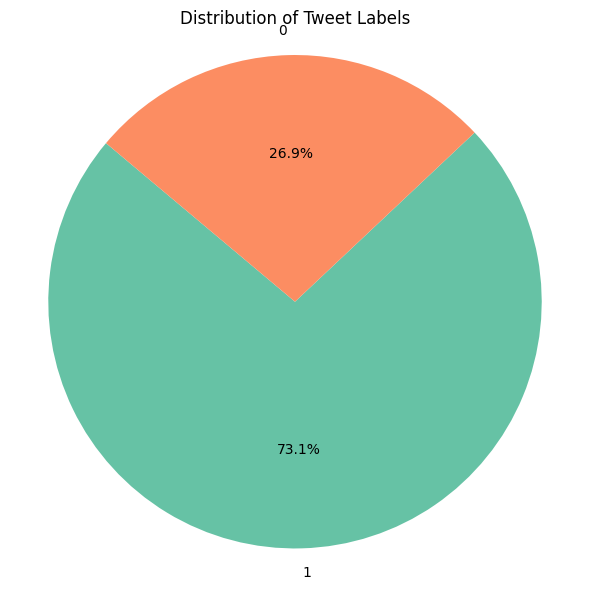

In [ ]:

# @title Plot the distribution of the label values
# Plot the distribution of the label values as a pie chart
plt.figure(figsize=(6, 6))
label_counts = df['Label'].value_counts()
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Set2'))
plt.title('Distribution of Tweet Labels')
plt.axis('equal')  # Equal aspect ratio ensures the pie chart is circular.
plt.tight_layout()
plt.show()


In [ ]:
# @title The Range of the data
print(df["Creation Time"].min(), df["Creation Time"].max())

2014-06-07 10:35:22 2025-05-27 12:17:25


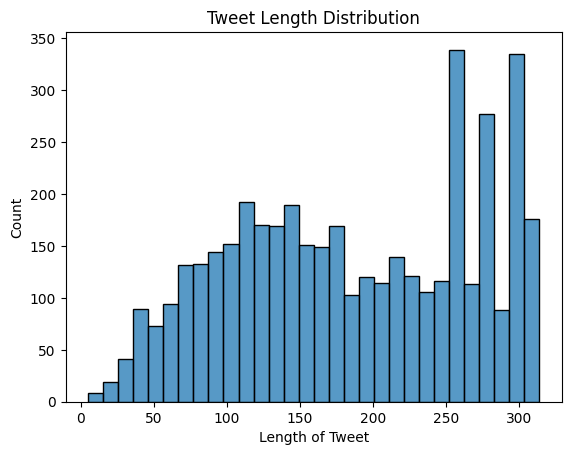

In [ ]:
#@title Tweet length distribution
df['text_length'] = df['Tweet Text'].apply(len)
# df['text_length'].describe()

# Plot distribution
# plt.figure(figsize=(10, 6))
# sns.histplot(df['text_length'], bins=30, kde=True, color='skyblue')
# plt.title('Distribution of Tweet Lengths')
# plt.xlabel('Tweet Length')
# plt.ylabel('Frequency')
# plt.grid(True)
# plt.show()
sns.histplot(df['text_length'], bins=30)
plt.title('Tweet Length Distribution')
plt.xlabel('Length of Tweet')
plt.ylabel('Count')
plt.show()

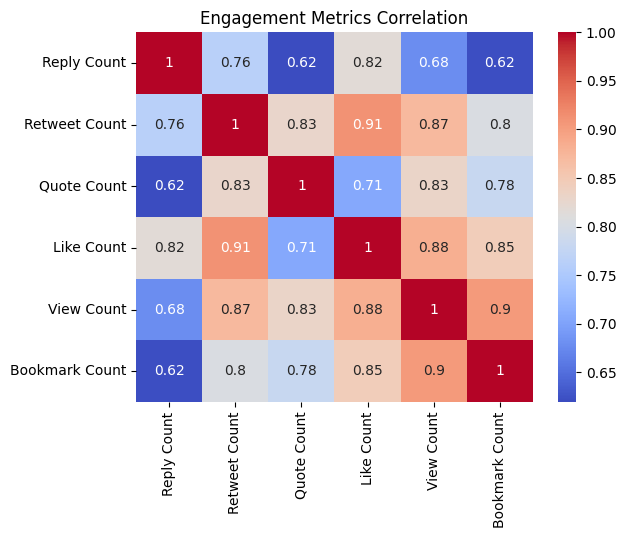

In [ ]:
#@title Correlation Heat Map
engagement_cols = ['Reply Count', 'Retweet Count', 'Quote Count', 'Like Count', 'View Count', 'Bookmark Count']
df[engagement_cols].describe()

# Correlation heatmap
sns.heatmap(df[engagement_cols].corr(), annot=True, cmap='coolwarm')
plt.title('Engagement Metrics Correlation')
plt.show()


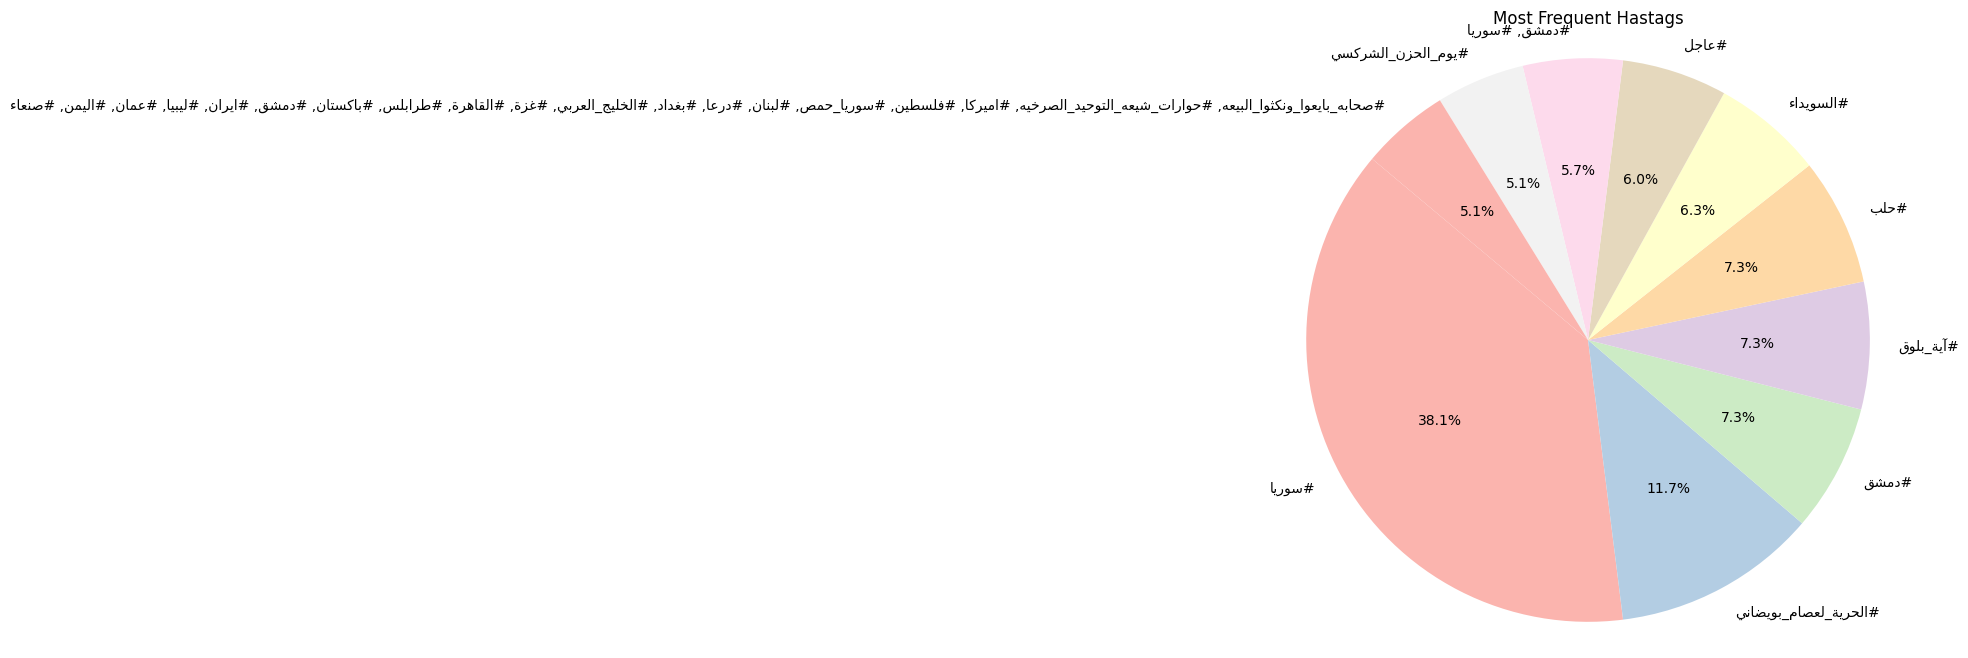

In [ ]:
#@title Frequent Hashtags
# Prepare hashtag counts
all_hashtags = df['Hashtags'].dropna().apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else [x])
flattened = [tag for sublist in all_hashtags for tag in sublist]
hashtag_counts = Counter(flattened)

# Extract top 10 hashtags
top_hashtags = hashtag_counts.most_common(10)
labels, counts = zip(*top_hashtags)

# Reshape and reorder Arabic labels
reshaped_labels = [get_display(arabic_reshaper.reshape(label)) for label in labels]

# Plot pie chart
plt.figure(figsize=(8, 8))
plt.pie(counts, labels=reshaped_labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title("Most Frequent Hastags")
plt.axis('equal')  # Equal aspect ratio ensures pie is circular.
plt.show()


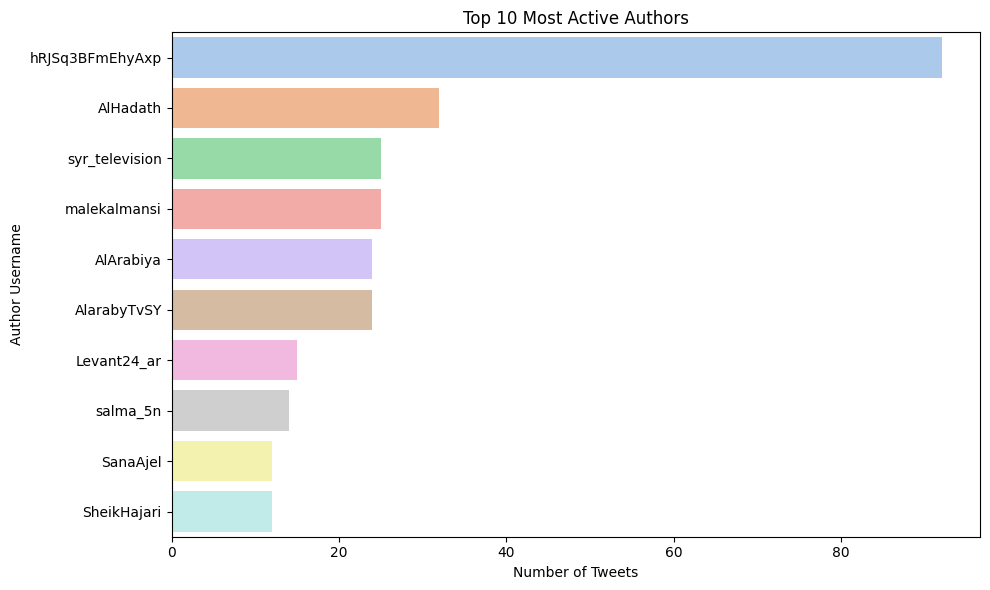

In [ ]:
# @title Most active authors

top_authors = df['Author Username'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_authors.values, y=top_authors.index, palette='pastel',hue=top_authors.index)
plt.title('Top 10 Most Active Authors')
plt.xlabel('Number of Tweets')
plt.ylabel('Author Username')
plt.tight_layout()
plt.show()

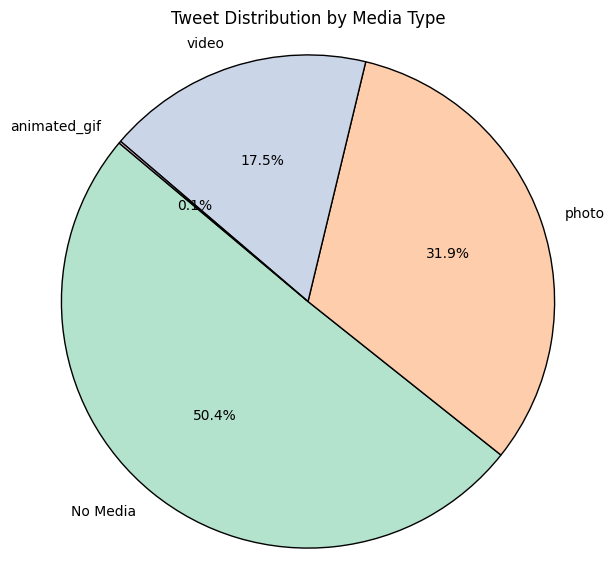

In [ ]:
#@title Media Type
import matplotlib.pyplot as plt

# Get media type counts including NaNs
media_counts = df['Media Type'].value_counts(dropna=False)

# Replace NaN label with 'No Media'
media_counts.index = media_counts.index.fillna('No Media')

plt.figure(figsize=(7,7))
plt.pie(
    media_counts,
    labels=media_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.Pastel2.colors,
    wedgeprops={'edgecolor': 'black'}
)
plt.title('Tweet Distribution by Media Type')
plt.axis('equal')
plt.show()



In [ ]:
#@title External URLs presence
ext_urls=df['External URLs'].notnull().sum()
print(f"Number of tweets with external URLs: {ext_urls}")

Number of tweets with external URLs: 281


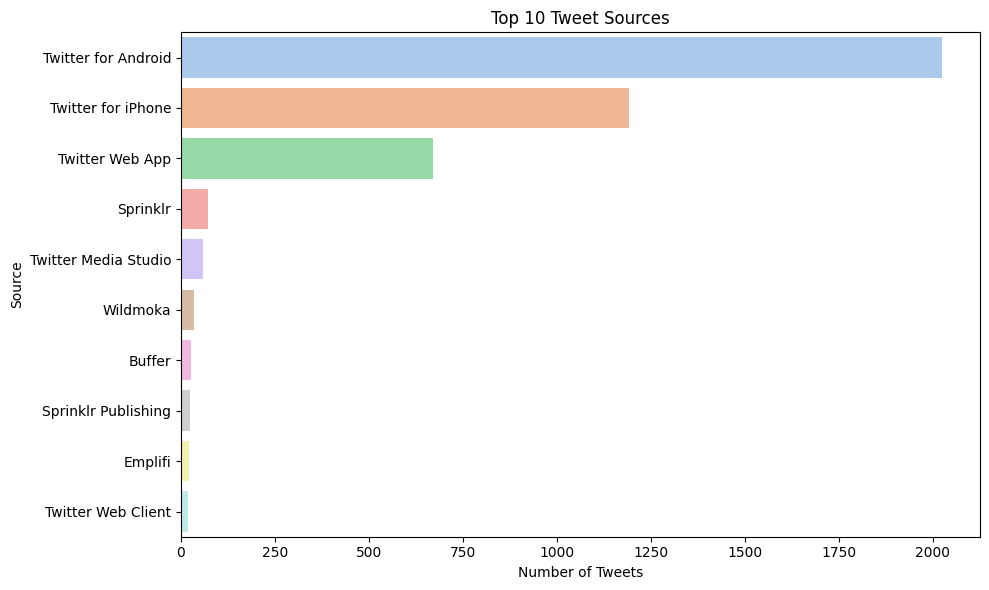

In [ ]:

#@title Most common sources (devices/apps used)

# Get top 10 sources
top_sources = df['Source'].value_counts().head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_sources.values, y=top_sources.index, palette='pastel',hue=top_sources.index)
plt.title('Top 10 Tweet Sources')
plt.xlabel('Number of Tweets')
plt.ylabel('Source')
plt.tight_layout()
plt.show()

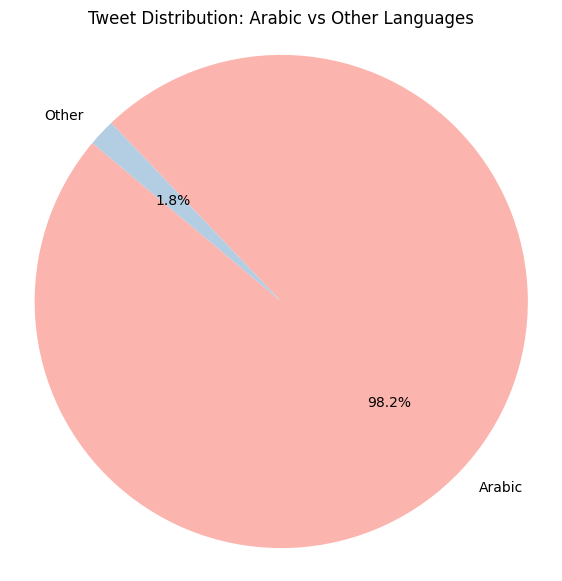

In [ ]:
#@title Languages Distribution
# Count languages
language_counts = df['Language'].value_counts()

arabic_lang = 'ar'  # change if needed
arabic_count = language_counts.get(arabic_lang, 0)

# Sum of all non-Arabic languages
other_count = language_counts.sum() - arabic_count

# Create series for pie chart
pie_counts = [arabic_count, other_count]
labels = ['Arabic', 'Other']

# Plot pie chart
plt.figure(figsize=(7,7))
plt.pie(pie_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title('Tweet Distribution: Arabic vs Other Languages')
plt.axis('equal')  # Make pie circular
plt.show()


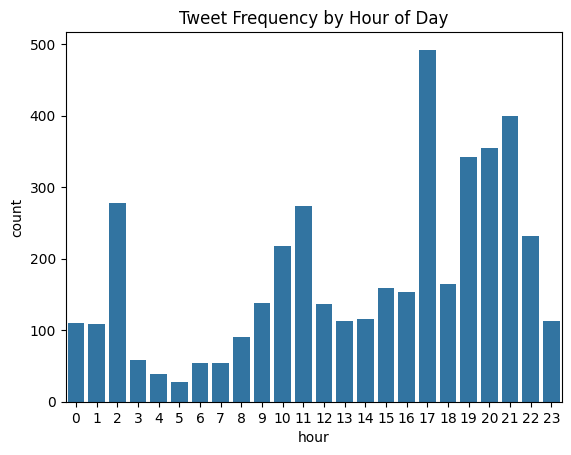

In [ ]:
# @title Tweet Frequency by Hour
# Extract hour and date
df['hour'] = df['Creation Time'].dt.hour
df['date'] = df['Creation Time'].dt.date

# Plot tweet frequency by hour
sns.countplot(x='hour', data=df)
plt.title('Tweet Frequency by Hour of Day')
plt.show()


<ipython-input-100-2e1a0f503a1e>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_df['Word Count'] = day_df['Tweet Text'].str.split().apply(len)


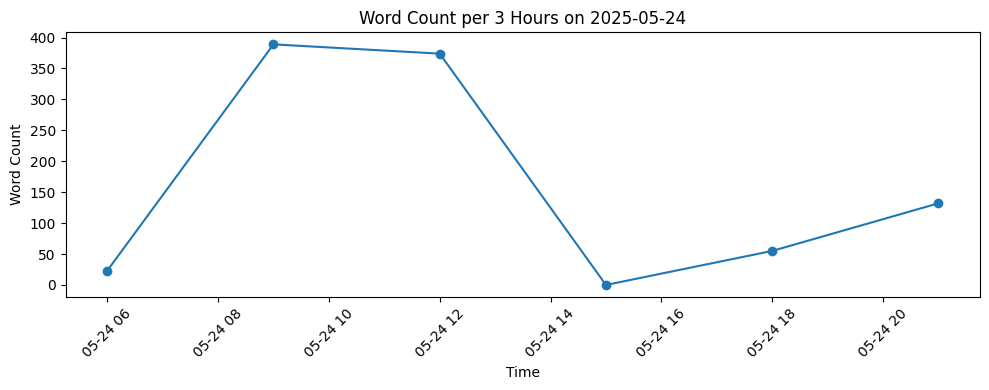

In [ ]:
# @title Word Count per 3 Hours on A Day
# Select a specific date (e.g., May 21, 2025)
selected_day = '2025-05-24'
day_df = df[df['Creation Time'].dt.date == pd.to_datetime(selected_day).date()]

# Create a new column with word count
day_df['Word Count'] = day_df['Tweet Text'].str.split().apply(len)

# Set datetime index to resample
day_df = day_df.set_index('Creation Time')

# Resample every 3 hours and sum word counts
word_counts_3h = day_df['Word Count'].resample('3h').sum()

# Plot
plt.figure(figsize=(10, 4))
plt.plot(word_counts_3h.index, word_counts_3h.values, marker='o')
plt.title(f'Word Count per 3 Hours on {selected_day}')
plt.xlabel('Time')
plt.ylabel('Word Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

downloading and unzipping arabic font: /usr/local/lib/python3.11/dist-packages/ar_wordcloud/fonts/NotoNaskhArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.11/dist-packages/ar_wordcloud/fonts/NotoSansArabic-unhinted.zip .. 
downloading and unzipping arabic font: /usr/local/lib/python3.11/dist-packages/ar_wordcloud/fonts/NotoKufiArabic-unhinted.zip .. 


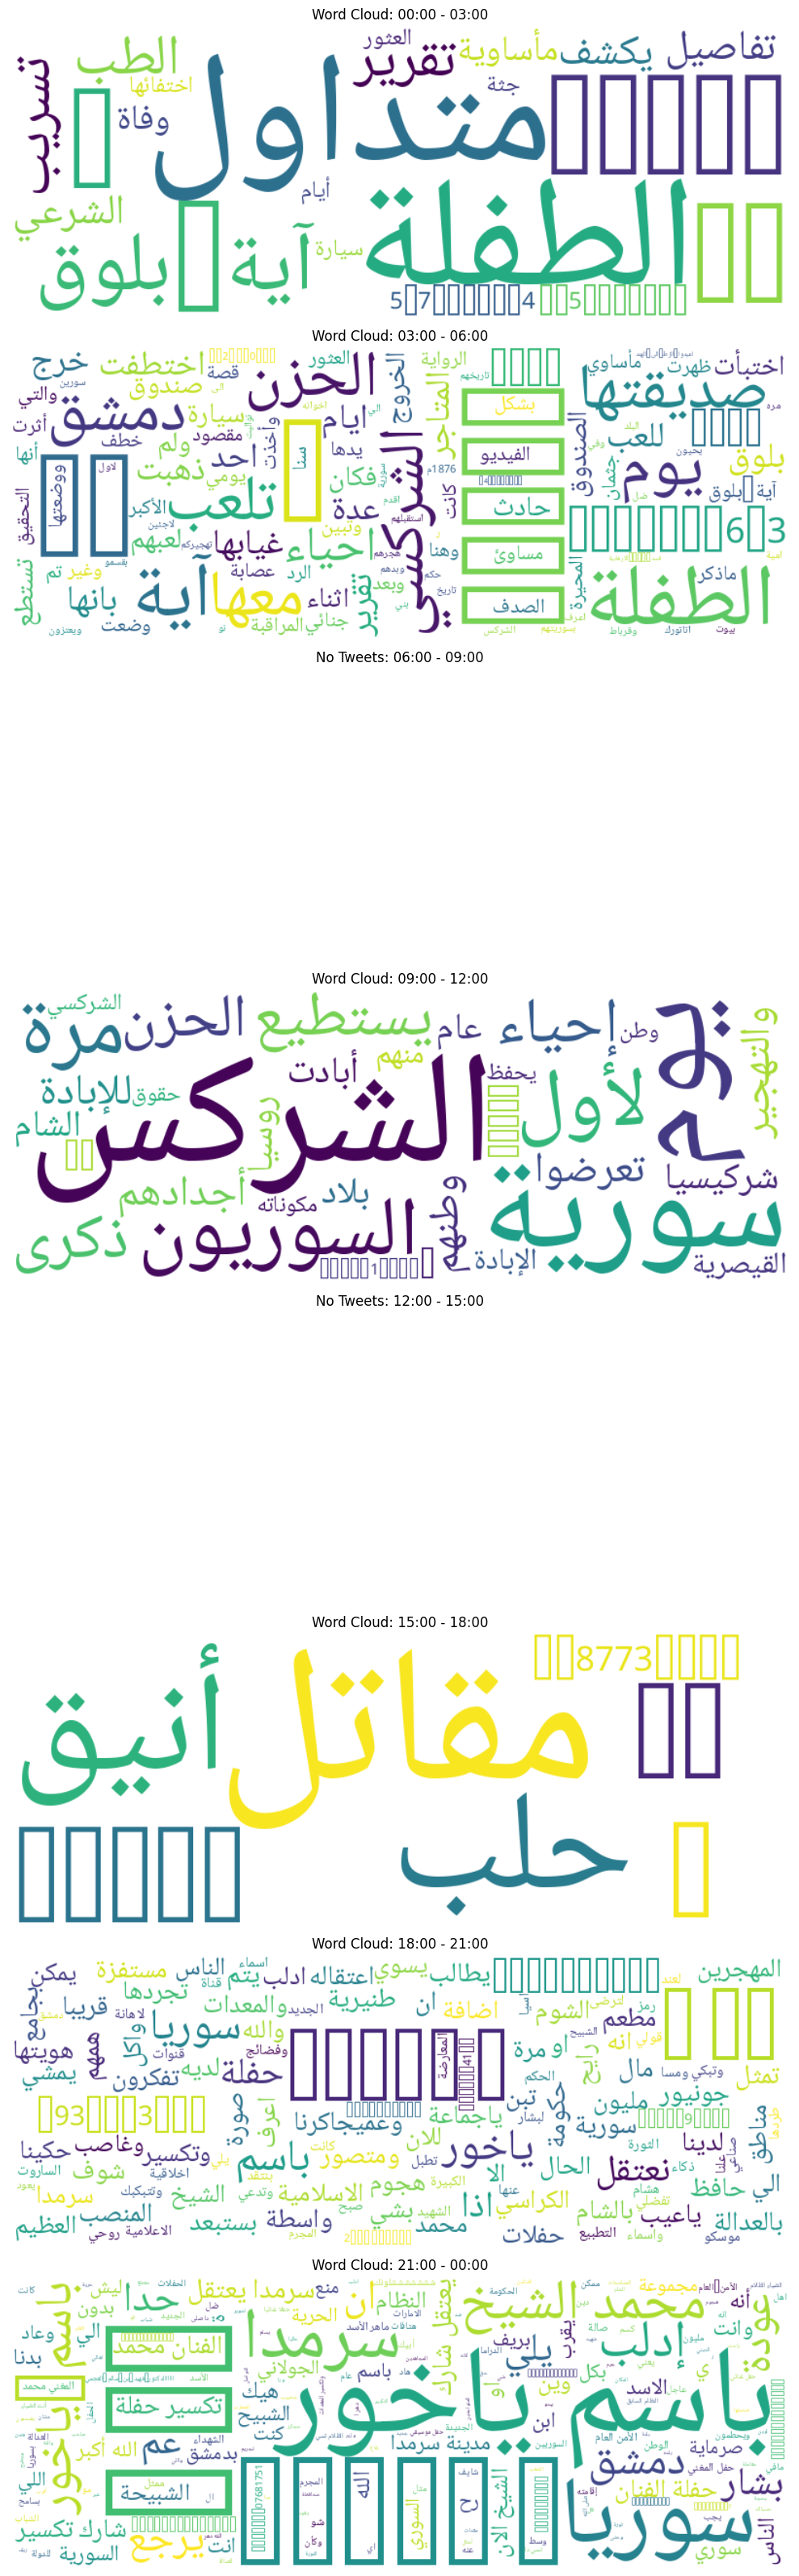

In [ ]:
#@title  word cloud for a day
# Filter tweets for the selected day first
selected_day = '2025-05-23'
day_df = df[df['Creation Time'].dt.date == pd.to_datetime(selected_day).date()].copy()
day_df = day_df.set_index('Creation Time')

# Resample every 3 hours
intervals = list(day_df.resample('3h'))

# Create subplots
fig, axs = plt.subplots(len(intervals), 1, figsize=(10, 4 * len(intervals)))
if len(intervals) == 1:
    axs = [axs]

for i, (time_bin, group) in enumerate(intervals):
    # Join all tweet texts into one string
    all_text = ' '.join(group['Tweet Text'].dropna().astype(str))

    if all_text.strip():
        # Remove stop words
        words = all_text.split()
        filtered_words = [w for w in words if w not in arabic_stopwords]
        filtered_text = ' '.join(filtered_words)

        # Generate Arabic word cloud
        wc = ArabicWordCloud(
            width=800,
            height=300,
            background_color='white'
        ).generate(filtered_text)

        axs[i].imshow(wc, interpolation='bilinear')
        axs[i].axis('off')
        axs[i].set_title(f'Word Cloud: {time_bin.strftime("%H:%M")} - {(time_bin + pd.Timedelta(hours=3)).strftime("%H:%M")}')
    else:
        axs[i].axis('off')
        axs[i].set_title(f'No Tweets: {time_bin.strftime("%H:%M")} - {(time_bin + pd.Timedelta(hours=3)).strftime("%H:%M")}')

plt.tight_layout()
plt.show()


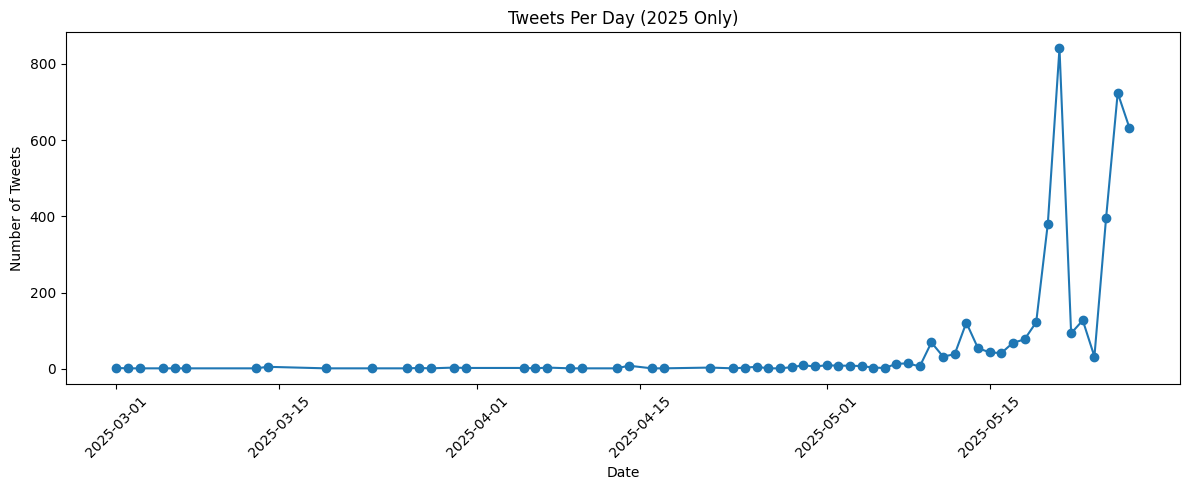

In [ ]:
#@title Tweets Per Day

# Ensure 'date' column is of type Timestamp
df['date'] = pd.to_datetime(df['date'])

# Filter only tweets from 2025 onwards
df_filtered = df[df['date'] >= pd.Timestamp('2025-3-01')]

# Count tweets per day
daily_counts = df_filtered['date'].value_counts().sort_index()

# Plot
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
plt.plot(daily_counts.index, daily_counts.values, marker='o')
plt.title('Tweets Per Day (2025 Only)')
plt.xlabel('Date')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


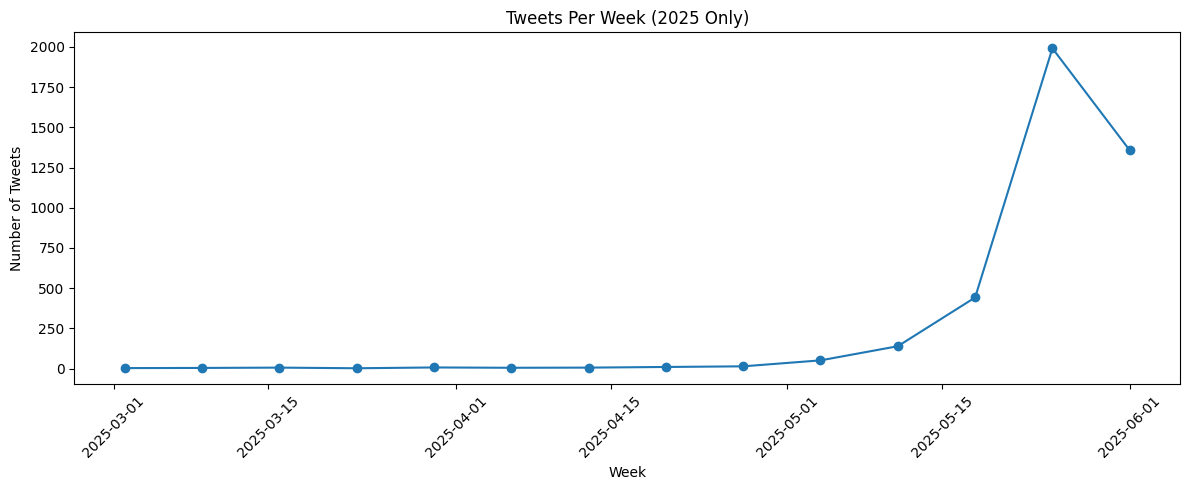

In [ ]:
# @title Tweets Per Week
# Filter only tweets from 2025
df_filtered = df[df['date'] >= pd.Timestamp('2025-03-01')]

# Set 'date' as index for resampling
df_filtered = df_filtered.set_index('date')

# Group by week and count tweets
weekly_counts = df_filtered.resample('W').size()

# Plot
plt.figure(figsize=(12, 5))
plt.plot(weekly_counts.index, weekly_counts.values, marker='o')
plt.title('Tweets Per Week (2025 Only)')
plt.xlabel('Week')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


<ipython-input-108-06d477f9f35a>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df_filtered, x='Label', palette='Set1')


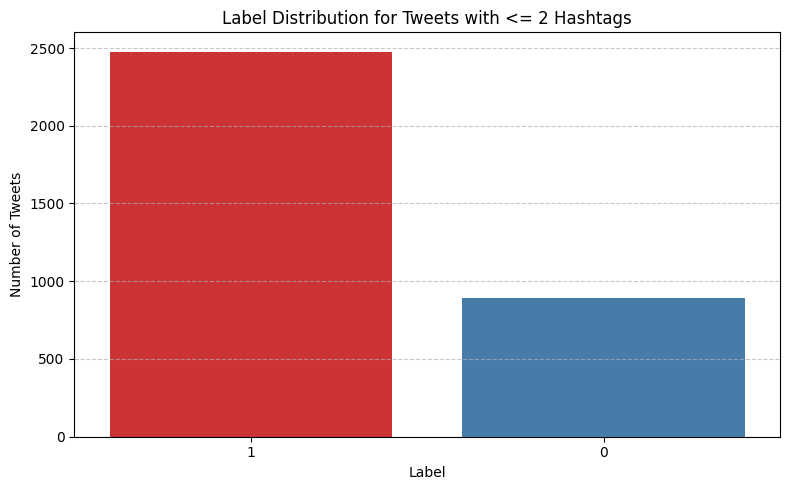

In [ ]:
#@title Hashtag Count

# Create a new column for hashtag counts
df['HashtagCount'] = df['Tweet Text'].apply(count_hashtags)

# Filter tweets with more than 4 hashtags
df_filtered = df[df['HashtagCount'] <=2]

# Plot the label distribution
plt.figure(figsize=(8, 5))
sns.countplot(data=df_filtered, x='Label', palette='Set1')
plt.title('Label Distribution for Tweets with <= 2 Hashtags')
plt.xlabel('Label')
plt.ylabel('Number of Tweets')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


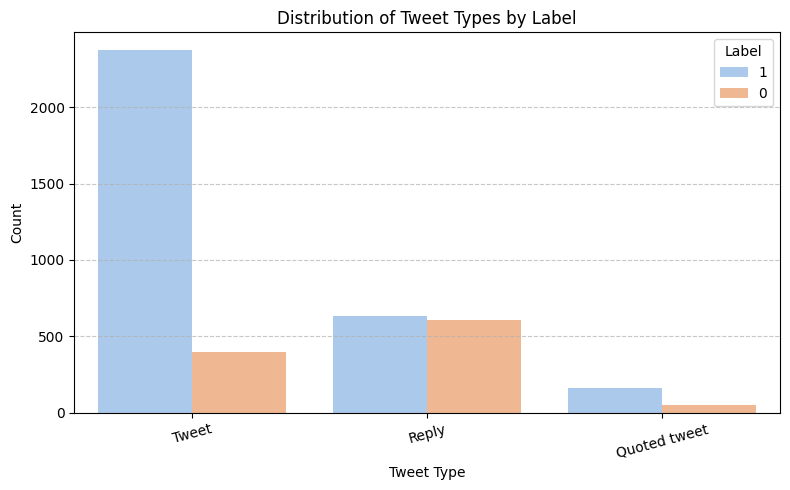

In [ ]:
#@title Tweets Type
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='Type', hue='Label', palette='pastel')

plt.title('Distribution of Tweet Types by Label')
plt.xlabel('Tweet Type')
plt.ylabel('Count')
plt.legend(title='Label', loc='upper right')
plt.xticks(rotation=15)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



100%|██████████| 132/132 [37:49<00:00, 17.20s/it]


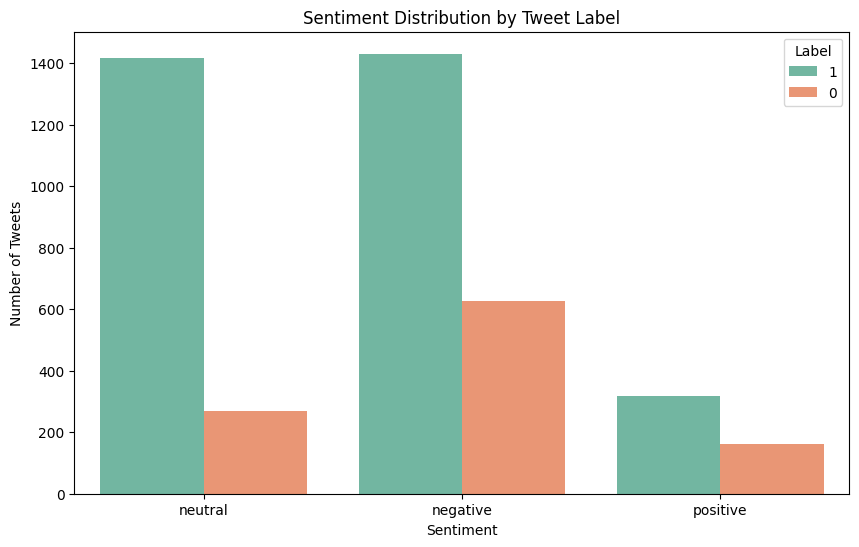

In [ ]:
#@title Sentiment Analysis
# Run sentiment analysis (this might take time if the dataset is large)
df['Sentiment'] = batch_predict(df['Tweet Text'].tolist())

plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Sentiment', hue='Label', palette='Set2')
plt.title('Sentiment Distribution by Tweet Label')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.legend(title='Label', loc='upper right')

In [ ]:
#@title Perdicate Sentiment
# df['Sentiment'] = df['Tweet Text'].apply(predict_sentiment)

df['Sentiment'] = batch_predict(df['Tweet Text'].tolist(), batch_size=32)


100%|██████████| 312/312 [1:06:01<00:00, 12.70s/it]


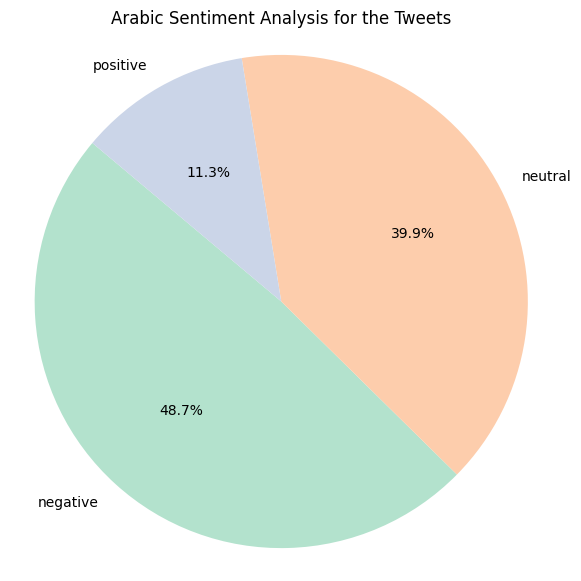

In [ ]:

# @title Plot sentiment distribution
sentiment_counts = df['Sentiment'].value_counts()
labels = sentiment_counts.index.tolist()
counts = sentiment_counts.values.tolist()

# Plot
plt.figure(figsize=(7, 7))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel2.colors)
plt.title("Arabic Sentiment Analysis for the Tweets")
plt.axis('equal')
plt.show()

In [ ]:
#@title Hate Speech Detection
df['HateSpeech'] = batch_predict_hate(df['Tweet Text'].tolist(), batch_size=64)

100%|██████████| 66/66 [29:48<00:00, 27.09s/it]


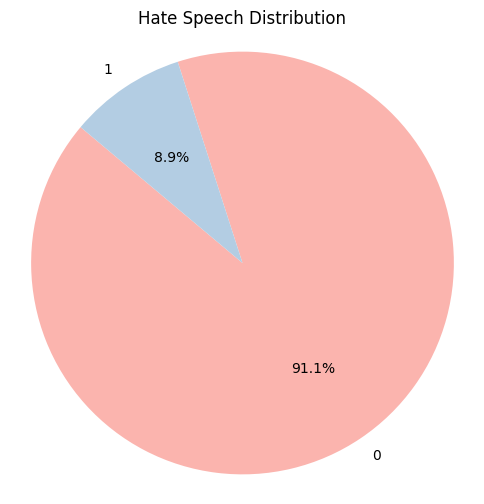

In [ ]:
#@title Hate Speach Distribution
counts = df['HateSpeech'].value_counts()
plt.figure(figsize=(6, 6))
plt.pie(counts, labels=counts.index, autopct='%1.1f%%', startangle=140, colors=plt.cm.Pastel1.colors)
plt.title("Hate Speech Distribution")
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


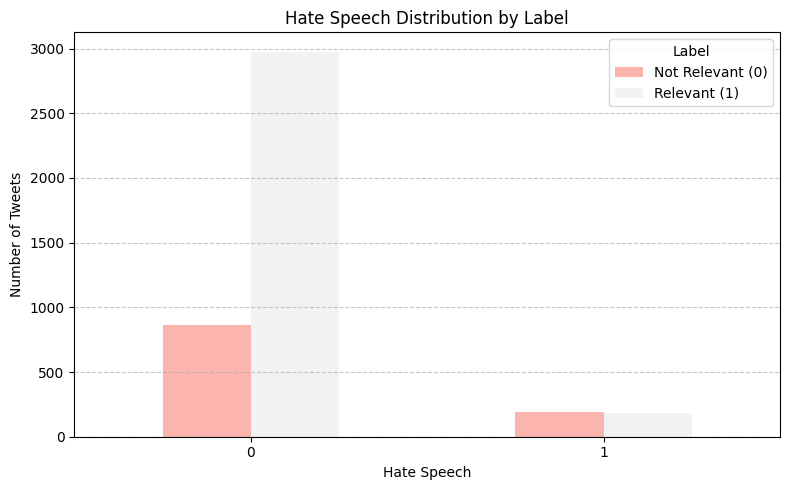

In [ ]:
#@title Hate Speech Distribution
# Create a crosstab of HateSpeech vs Label
hate_label_dist = pd.crosstab(df['HateSpeech'], df['Label'])

# Plot
hate_label_dist.plot(
    kind='bar',
    stacked=False,
    figsize=(8, 5),
    colormap='Pastel1'
)

plt.title("Hate Speech Distribution by Label")
plt.xlabel("Hate Speech")
plt.ylabel("Number of Tweets")
plt.xticks(rotation=0)
plt.legend(title='Label', labels=['Not Relevant (0)', 'Relevant (1)'])
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
#@title Extract Named Entites
from concurrent.futures import ThreadPoolExecutor

# Use ThreadPool to speed up processing
texts = df['Tweet Text'].tolist()

with ThreadPoolExecutor(max_workers=8) as executor:
    named_entities = list(executor.map(extract_entities_stanza, texts))

df['Named Entities'] = named_entities


In [ ]:
#@title Some Named Entities
df['Named Entities'].sample(4)

,Named Entities
1406,"[مخيم الهول, دير الزور]"
111,[]
1121,"[المرصد السوري, حلب, قوات سوريا الديمقراطية, ح..."
313,"[بورتسودان, الإمارات]"


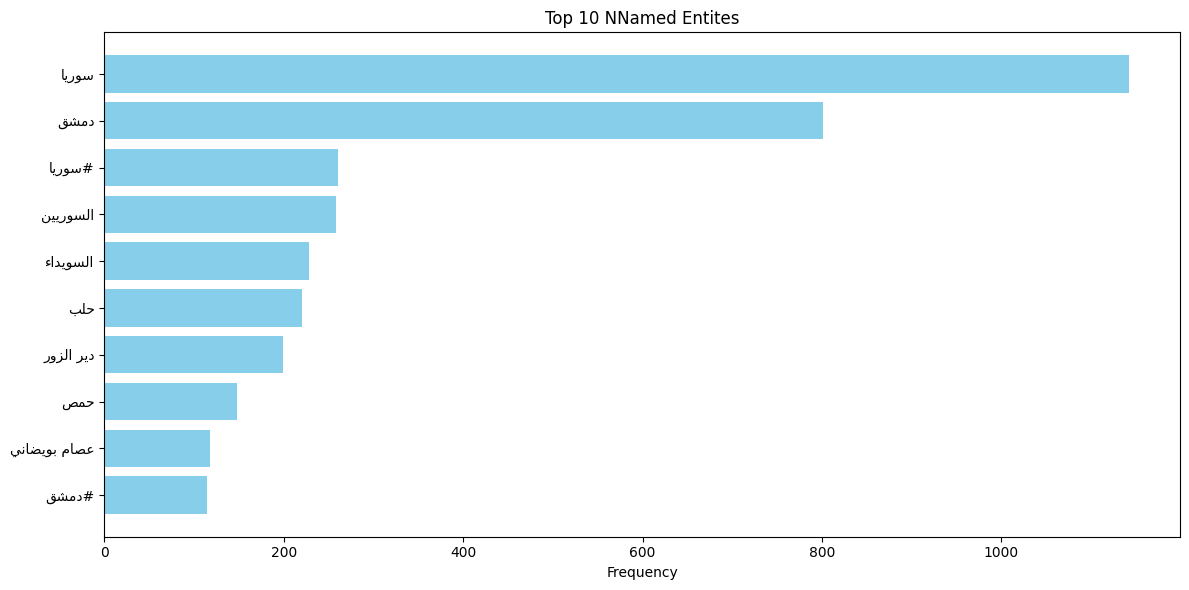

In [ ]:
#@title Top Named Entities
# Flatten all named entities from the dataframe column into a single list
all_entities = [ent for sublist in df['Named Entities'] for ent in sublist]

# Count frequency of each entity
entity_counts = Counter(all_entities)

# Get top 10 entities and their counts
top_entities = entity_counts.most_common(10)
entities, counts = zip(*top_entities)

# Reshape and reorder Arabic entity labels for correct display
reshaped_entities = [get_display(arabic_reshaper.reshape(ent)) for ent in entities]

# Plot bar chart
plt.figure(figsize=(12, 6))
plt.barh(reshaped_entities[::-1], counts[::-1], color='skyblue')  # reversed for descending order
plt.xlabel('Frequency')
plt.title("Top 10 NNamed Entites")
plt.tight_layout()
plt.show()


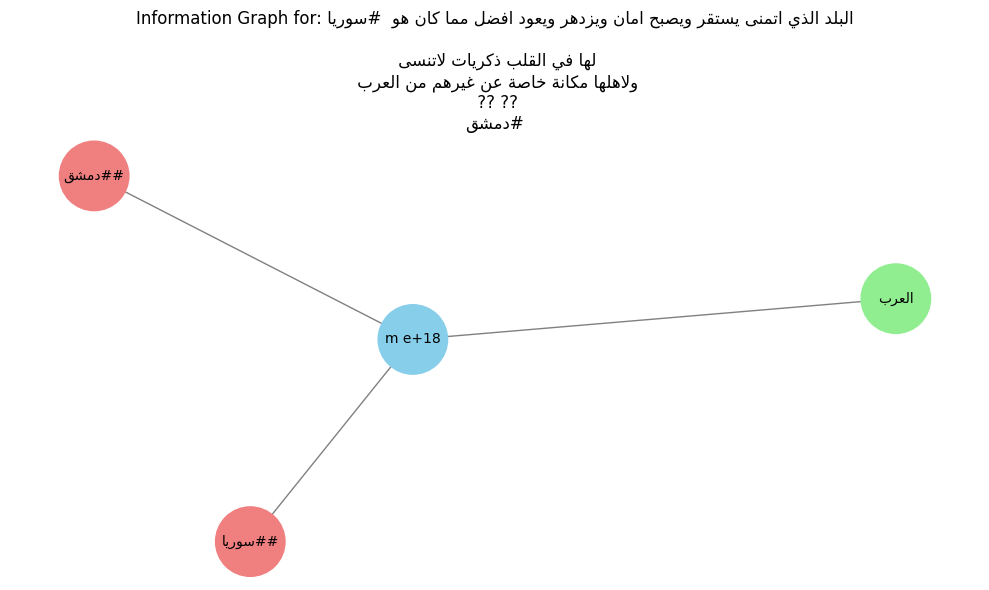

In [ ]:
#@title Message Attribute Graph for un relevant tweet
import networkx as nx
import matplotlib.pyplot as plt
import random
import arabic_reshaper
from bidi.algorithm import get_display

# Choose a single tweet randomly from your dataframe
random.seed(2342)
random_idx = random.choice(df.index)

irrelevant_df = df[df['Label'] == 0]

row = irrelevant_df.sample(1).iloc[0]

# Determine the entity column name
if 'Named Entities' in df.columns:
    entity_col = 'Named Entities'
elif 'entities' in df.columns:
    entity_col = 'entities'
else:
    raise ValueError("No entity column found; please check your dataframe")

G = nx.Graph()
# Create node for the tweet
tweet_node = f"m {str(row['Tweet ID'])[-4:]}"  # last 4 chars of Tweet ID
G.add_node(tweet_node, label='tweet', color='skyblue')

# Add entity nodes and edges
entities = row.get(entity_col, [])
if not isinstance(entities, list):
    entities = []

for entity in entities:
    if isinstance(entity, (tuple, list)):
        entity_text = str(entity[0]).strip()
    else:
        entity_text = str(entity).strip()

    # Reshape and reorder Arabic text for correct display
    reshaped_text = arabic_reshaper.reshape(entity_text)
    display_text = get_display(reshaped_text)

    G.add_node(display_text, label='entity', color='lightgreen')
    G.add_edge(tweet_node, display_text)

# Add hashtag nodes and edges
hashtags = row.get('Hashtags', [])
if not isinstance(hashtags, list):
    if isinstance(hashtags, str):
        if ',' in hashtags:
            hashtags = [h.strip() for h in hashtags.split(',') if h.strip()]
        else:
            hashtags = [h.strip() for h in hashtags.split() if h.strip()]
    else:
        hashtags = []

for hashtag in hashtags:
    hashtag_text = f"#{hashtag.strip().lower()}"
    reshaped_text = arabic_reshaper.reshape(hashtag_text)
    display_text = get_display(reshaped_text)

    G.add_node(display_text, label='hashtag', color='lightcoral')
    G.add_edge(tweet_node, display_text)

# Plotting the graph
pos = nx.spring_layout(G, seed=42)
node_colors = [data['color'] for _, data in G.nodes(data=True)]

plt.figure(figsize=(10, 6))
nx.draw_networkx(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    font_size=10,
    node_size=2500,
    edge_color='gray'
)
plt.title(f"Information Graph for: {get_display(arabic_reshaper.reshape(row['Tweet Text']))}")
plt.axis('off')
plt.tight_layout()
plt.show()


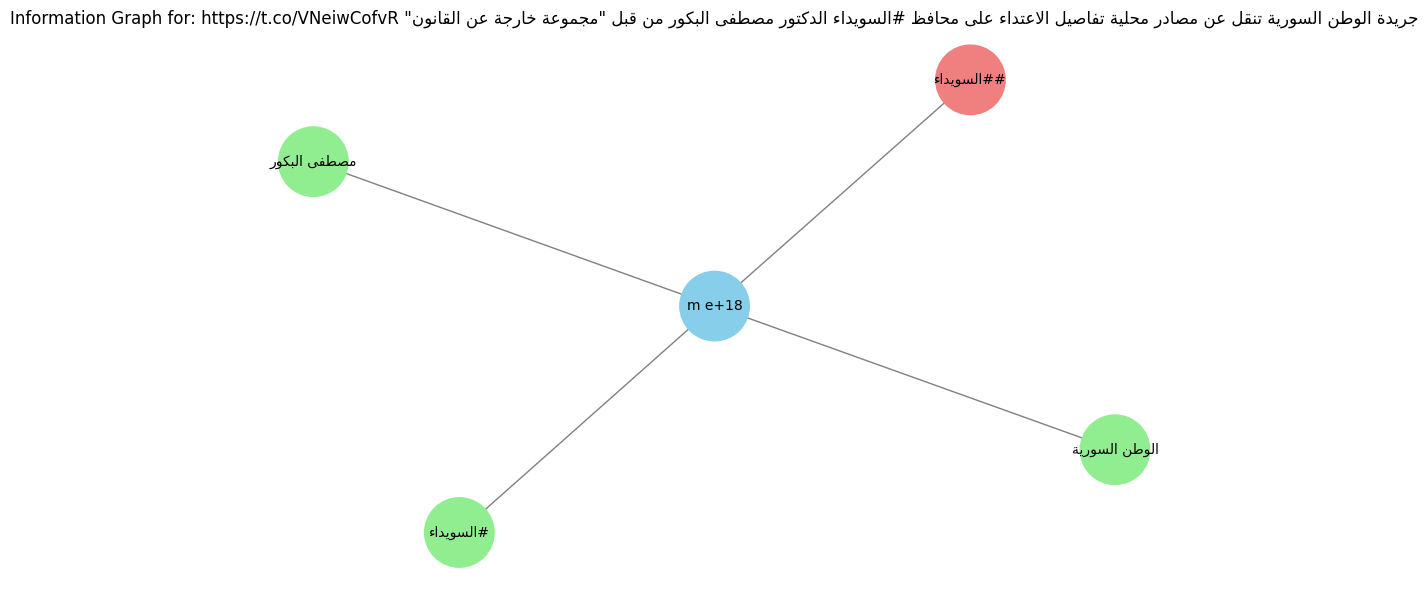

In [ ]:
#@title Message Attribute Graph for relevant tweet
import networkx as nx
import matplotlib.pyplot as plt
import random
import arabic_reshaper
from bidi.algorithm import get_display

# Choose a single tweet randomly from your dataframe
random.seed(2342)
random_idx = random.choice(df.index)

irrelevant_df = df[df['Label'] == 1]

row = irrelevant_df.sample(1).iloc[0]

# Determine the entity column name
if 'Named Entities' in df.columns:
    entity_col = 'Named Entities'
elif 'entities' in df.columns:
    entity_col = 'entities'
else:
    raise ValueError("No entity column found; please check your dataframe")

G = nx.Graph()
# Create node for the tweet
tweet_node = f"m {str(row['Tweet ID'])[-4:]}"  # last 4 chars of Tweet ID
G.add_node(tweet_node, label='tweet', color='skyblue')

# Add entity nodes and edges
entities = row.get(entity_col, [])
if not isinstance(entities, list):
    entities = []

for entity in entities:
    if isinstance(entity, (tuple, list)):
        entity_text = str(entity[0]).strip()
    else:
        entity_text = str(entity).strip()

    # Reshape and reorder Arabic text for correct display
    reshaped_text = arabic_reshaper.reshape(entity_text)
    display_text = get_display(reshaped_text)

    G.add_node(display_text, label='entity', color='lightgreen')
    G.add_edge(tweet_node, display_text)

# Add hashtag nodes and edges
hashtags = row.get('Hashtags', [])
if not isinstance(hashtags, list):
    if isinstance(hashtags, str):
        if ',' in hashtags:
            hashtags = [h.strip() for h in hashtags.split(',') if h.strip()]
        else:
            hashtags = [h.strip() for h in hashtags.split() if h.strip()]
    else:
        hashtags = []

for hashtag in hashtags:
    hashtag_text = f"#{hashtag.strip().lower()}"
    reshaped_text = arabic_reshaper.reshape(hashtag_text)
    display_text = get_display(reshaped_text)

    G.add_node(display_text, label='hashtag', color='lightcoral')
    G.add_edge(tweet_node, display_text)

# Plotting the graph
pos = nx.spring_layout(G, seed=42)
node_colors = [data['color'] for _, data in G.nodes(data=True)]

plt.figure(figsize=(10, 6))
nx.draw_networkx(
    G, pos,
    with_labels=True,
    node_color=node_colors,
    font_size=10,
    node_size=2500,
    edge_color='gray'
)
plt.title(f"Information Graph for: {get_display(arabic_reshaper.reshape(row['Tweet Text']))}")
plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
#@title Remove Non Arabic Tweets
# Keep only Arabic tweets based on the 'Language' column
df = df[df['Language'] == 'ar'].reset_index(drop=True)


In [ ]:
# @title Saving The Data Set
df.to_csv("processed_labeled.csv")

## E1 Text Embedding with Fast Text


In [ ]:
#@title Fix Dependency Issue
# !pip install scipy==1.10.1
# !pip uninstall -y numpy gensim
# !pip install numpy==1.24.3 gensim==4.3.1



In [ ]:
#@title Load the model
from gensim.models import KeyedVectors

# Load the .vec file (pre-trained FastText embeddings in text format)
fasttext_model = KeyedVectors.load_word2vec_format('cc.ar.300.vec', binary=False, encoding='utf-8')


In [71]:
#@title Embedding the tweets
import numpy as np

def embed_tweet(text, model):
    words = text.split()  # simple tokenization; you can replace with better Arabic tokenizer
    word_vectors = []

    for word in words:
        if word in model.key_to_index:
            word_vectors.append(model[word])
        else:
            # A zero vector if the word is OOV (out of vocab)
            word_vectors.append(np.zeros(model.vector_size))

    if word_vectors:
        # Aggregate word vectors by averaging
        tweet_vector = np.mean(word_vectors, axis=0)
    else:
        # Empty or no known words → zero vector
        tweet_vector = np.zeros(model.vector_size)

    return tweet_vector

# Apply embedding to entire DataFrame column, create new column with vectors
df['tweet_embedding'] = df['Tweet Text'].apply(lambda text: embed_tweet(text, fasttext_model))

# Example: check vector shape for first tweet
print(df['tweet_embedding'].iloc[0].shape)


(300,)


### Sipliting the Dataset

In [72]:
X = np.vstack(df['tweet_embedding'].values)
y = df['Label'].values


In [73]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### KNN

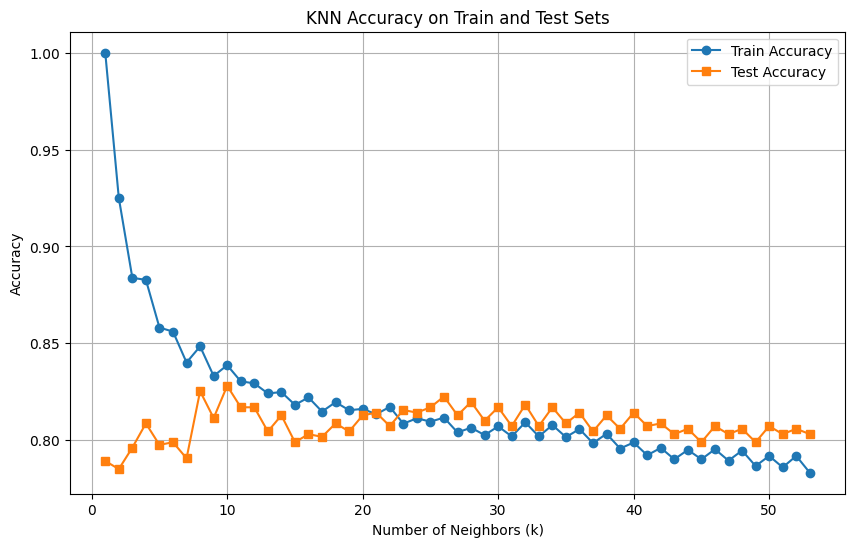

In [ ]:
#@title KNN with K from 1 to root of n
# Number of training samples
n_train = X_train.shape[0]

# Maximum k to try: integer part of sqrt(n_train)
max_k = int(sqrt(n_train))

# Store accuracies for train and test
train_accuracies = []
test_accuracies = []

k_values = range(1, max_k + 1)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict on train set and test set
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Calculate accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)


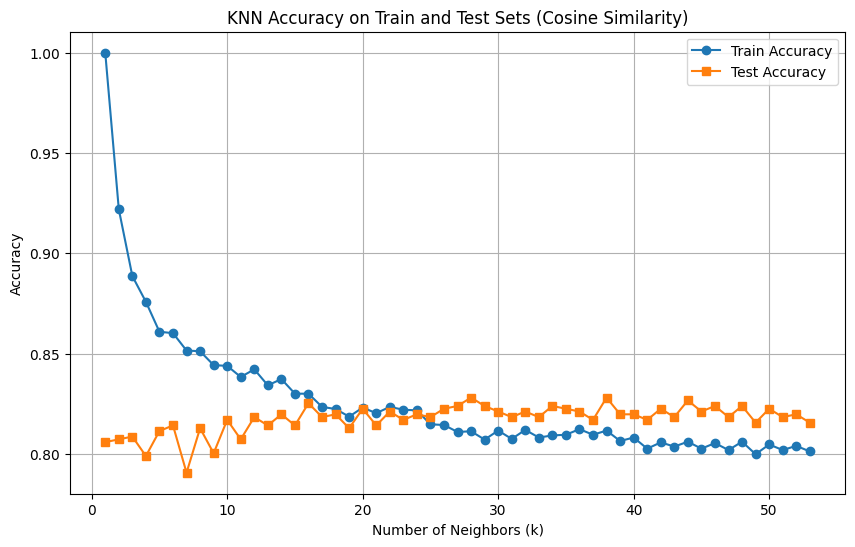

In [ ]:
#@title KNN with Cosine Similarity
# Number of training samples
n_train = X_train.shape[0]

# Maximum k to try: integer part of sqrt(n_train)
max_k = int(sqrt(n_train))

# Store accuracies for train and test
train_accuracies = []
test_accuracies = []

k_values = range(1, max_k + 1)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(X_train, y_train)

    # Predict on train set and test set
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Calculate accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy on Train and Test Sets (Cosine Similarity)')
plt.legend()
plt.grid(True)
plt.show()


#### Grid Search

In [ ]:
#@title KNN with Grid Search   Params
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(5, 41)),
    'metric': ['cosine', 'euclidean']  # Add more metrics if you want
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=2)


In [ ]:
#@title Fit the Model
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'metric': 'cosine', 'n_neighbors': 6}
Best cross-validation accuracy: 0.8429


In [ ]:
#@title Classfication Report
from sklearn.metrics import classification_report

best_knn = grid_search.best_estimator_

y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)

print("Classification Report - Training Set")
print(classification_report(y_train, y_train_pred))

print("Classification Report - Test Set")
print(classification_report(y_test, y_test_pred))


Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.78      0.67      0.72       783
           1       0.88      0.93      0.91      2099

    accuracy                           0.86      2882
   macro avg       0.83      0.80      0.81      2882
weighted avg       0.86      0.86      0.86      2882

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.65      0.61      0.63       185
           1       0.87      0.89      0.88       536

    accuracy                           0.81       721
   macro avg       0.76      0.75      0.75       721
weighted avg       0.81      0.81      0.81       721



### SVM

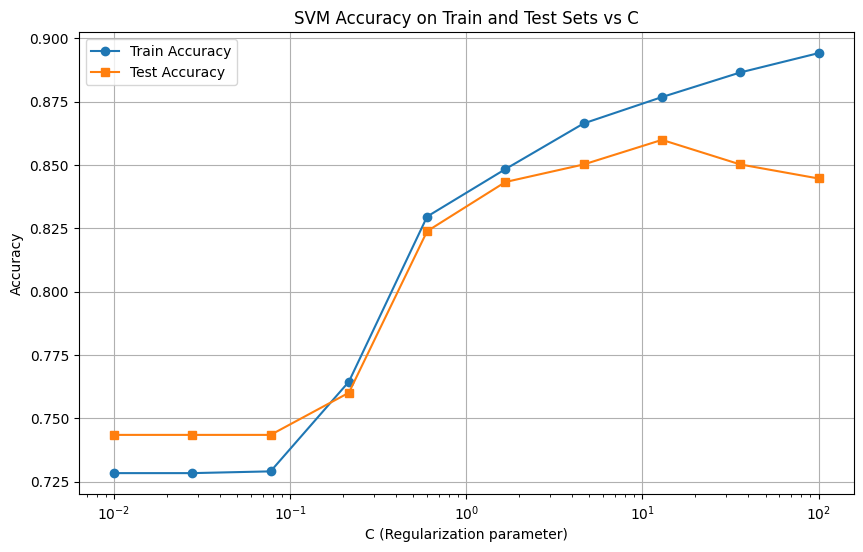

In [ ]:
#@title SVM with Linear kernel (jsut to show a base line )
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a range of C values to try (log scale)
C_values = np.logspace(-2, 2, 10)  # 0.01 to 100

train_accuracies = []
test_accuracies = []

for C in C_values:
    svm = SVC(C=C, kernel='linear')  # using linear kernel, you can try others like 'rbf'
    svm.fit(X_train, y_train)

    y_train_pred = svm.predict(X_train)
    y_test_pred = svm.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(C_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xscale('log')
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy on Train and Test Sets vs C')
plt.legend()
plt.grid(True)
plt.show()


#### Grid Search

In [85]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC()

param_grid = {
    'C': [0.01,0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly'],  # Kernel types to try
    'gamma': ['scale', 'auto']  # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
}

grid_search_svm = GridSearchCV(svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)



In [86]:
grid_search_svm.fit(X_train, y_train)

print(f"Best parameters: {grid_search_svm.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_svm.best_score_:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 100, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy: 0.7711


In [87]:
from sklearn.metrics import classification_report

best_svm = grid_search_svm.best_estimator_

y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)

print("Classification Report - Training Set")
print(classification_report(y_train, y_train_pred))

print("Classification Report - Test Set")
print(classification_report(y_test, y_test_pred))


Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.85      0.74      0.79       783
           1       0.91      0.95      0.93      2099

    accuracy                           0.89      2882
   macro avg       0.88      0.85      0.86      2882
weighted avg       0.89      0.89      0.89      2882

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.71      0.68      0.69       185
           1       0.89      0.90      0.90       536

    accuracy                           0.84       721
   macro avg       0.80      0.79      0.79       721
weighted avg       0.84      0.84      0.84       721



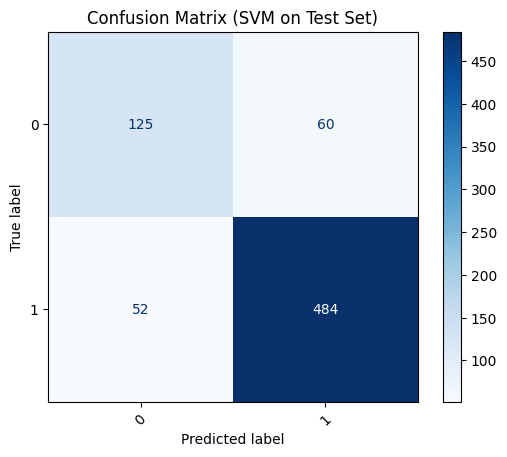

In [88]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict using the best model from GridSearch
y_pred = grid_search_svm.best_estimator_.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search_svm.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (SVM on Test Set)")
plt.grid(False)
plt.show()


In [89]:
import joblib

# Save the grid search SVM model to a file
joblib.dump(grid_search_svm, 'grid_search_svm_model.joblib')
print("SVM Grid Search model saved as 'grid_search_svm_model.joblib'")


SVM Grid Search model saved as 'grid_search_svm_model.joblib'


### Logistic Regression

In [74]:
#@title Logistic Regression with Default Parameters
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Train Accuracy: 0.8234
Test Accuracy: 0.8294


In [75]:
#@title Logistic Regression with Grid Search
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l2'],                   # L2 is commonly used
    'solver': ['liblinear', 'lbfgs'],    # liblinear for small data, lbfgs is default
}

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.8314


In [76]:
#@title Classification Report for Logistic Regression
from sklearn.metrics import classification_report

best_logreg = grid_search.best_estimator_

y_train_pred = best_logreg.predict(X_train)
y_test_pred = best_logreg.predict(X_test)

print("Classification Report - Training Set")
print(classification_report(y_train, y_train_pred))

print("Classification Report - Test Set")
print(classification_report(y_test, y_test_pred))


Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.82      0.73      0.77       783
           1       0.90      0.94      0.92      2099

    accuracy                           0.88      2882
   macro avg       0.86      0.83      0.85      2882
weighted avg       0.88      0.88      0.88      2882

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.72      0.71      0.71       185
           1       0.90      0.90      0.90       536

    accuracy                           0.85       721
   macro avg       0.81      0.81      0.81       721
weighted avg       0.85      0.85      0.85       721



<Figure size 600x600 with 0 Axes>

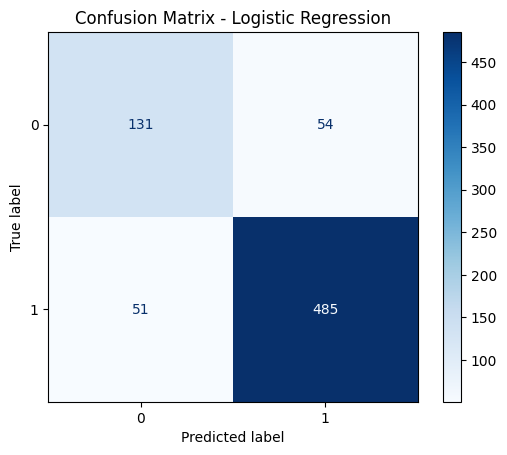

In [77]:
#@title Confusion Matrix for Logistic Regression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test set
y_test_pred = best_logreg.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=best_logreg.classes_)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_logreg.classes_)
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


### Naive Baise

In [82]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize Gaussian Naive Bayes
gnb = GaussianNB()

# Fit the model
gnb.fit(X_train, y_train)

# Predict on train and test
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)

# Print accuracies
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))


Train Accuracy: 0.7567661346287301
Test Accuracy: 0.7628294036061026


In [83]:
print("Classification Report - Training Set")
print(classification_report(y_train, y_train_pred))

print("Classification Report - Test Set")
print(classification_report(y_test, y_test_pred))


Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.56      0.50      0.53       783
           1       0.82      0.85      0.84      2099

    accuracy                           0.76      2882
   macro avg       0.69      0.67      0.68      2882
weighted avg       0.75      0.76      0.75      2882

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.54      0.55      0.54       185
           1       0.84      0.84      0.84       536

    accuracy                           0.76       721
   macro avg       0.69      0.69      0.69       721
weighted avg       0.76      0.76      0.76       721



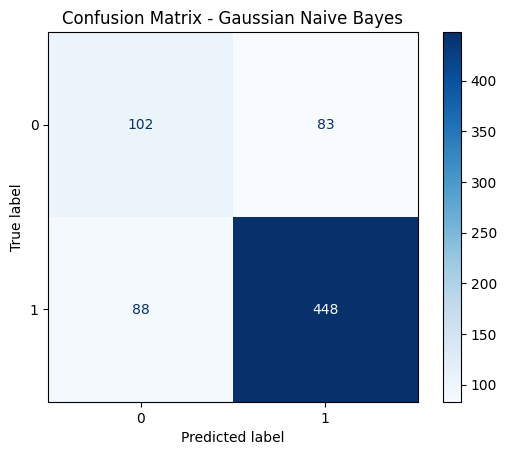

In [84]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()


## E2 Taking a wieght for the Named Entities

In [ ]:
#@title Load the model
from gensim.models import KeyedVectors

# Load the .vec file (pre-trained FastText embeddings in text format)
fasttext_model = KeyedVectors.load_word2vec_format('cc.ar.300.vec', binary=False, encoding='utf-8')


In [ ]:
#@title Weighting the embeding by the named entites
import numpy as np
import ast


# Weighted Embedding Function
def embed_tweet_weighted(text, named_entities, model, ner_weight=2.0):
    words = str(text).split()  # ensure string and basic tokenization
    named_entities_set = set(named_entities if isinstance(named_entities, list) else [])

    weighted_vectors = []
    weights = []

    for word in words:
        # Get vector
        word_vector = model[word] if word in model.key_to_index else np.zeros(model.vector_size)
        # Weight: more for NER
        weight = ner_weight if word in named_entities_set else 1.0

        weighted_vectors.append(word_vector * weight)
        weights.append(weight)

    if weighted_vectors:
        tweet_vector = np.sum(weighted_vectors, axis=0) / (np.sum(weights) or 1.0)
    else:
        tweet_vector = np.zeros(model.vector_size)

    return tweet_vector

#  Add new column with weighted embeddings
df['weighted_tweet_embedding'] = df.apply(
    lambda row: embed_tweet_weighted(row['Tweet Text'], row['Named Entities'], fasttext_model),
    axis=1
)

# Check
print(df['weighted_tweet_embedding'].iloc[0].shape)


(300,)


### split the DF

In [ ]:
X = np.vstack(df['weighted_tweet_embedding'].values)
y = df['Label'].values


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### KNN

In [ ]:
#@title KNN with K from 1 to root of n
# Number of training samples
n_train = X_train.shape[0]

# Maximum k to try: integer part of sqrt(n_train)
max_k = int(sqrt(n_train))

# Store accuracies for train and test
train_accuracies = []
test_accuracies = []

k_values = range(1, max_k + 1)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict on train set and test set
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Calculate accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy on Train and Test Sets (Cosine Similarity)')
plt.legend()
plt.grid(True)
plt.show()



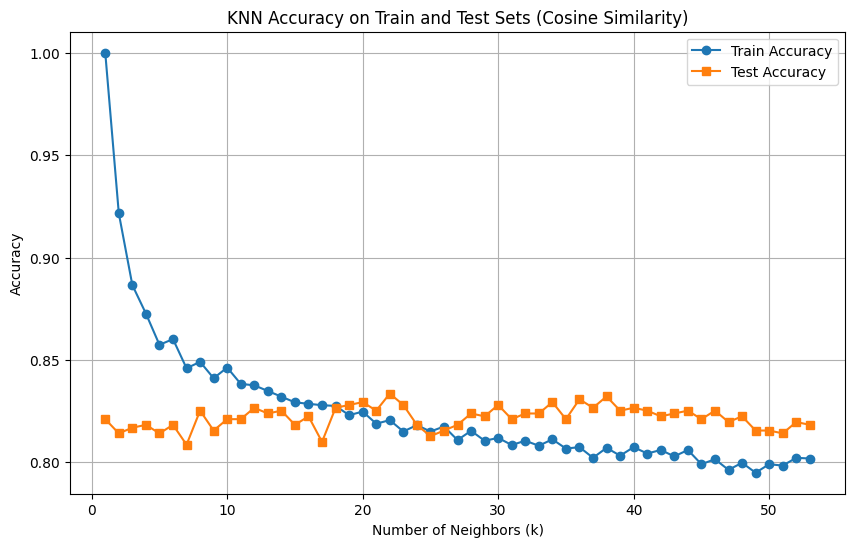

In [ ]:
#@title KNN with Cosine Similarity
# Number of training samples
n_train = X_train.shape[0]

# Maximum k to try: integer part of sqrt(n_train)
max_k = int(sqrt(n_train))

# Store accuracies for train and test
train_accuracies = []
test_accuracies = []

k_values = range(1, max_k + 1)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(X_train, y_train)

    # Predict on train set and test set
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Calculate accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy on Train and Test Sets (Cosine Similarity)')
plt.legend()
plt.grid(True)
plt.show()


#### Grid Search

In [ ]:
#@title KNN with Grid Search   Params
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(5, 41)),
    'metric': ['cosine', 'euclidean']  # Add more metrics if you want
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=2)


In [ ]:
#@title Fit the Model
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'metric': 'cosine', 'n_neighbors': 6}
Best cross-validation accuracy: 0.8391


In [ ]:
#@title Classfication Report
from sklearn.metrics import classification_report

best_knn = grid_search.best_estimator_

y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)

print("Classification Report - Training Set")
print(classification_report(y_train, y_train_pred))

print("Classification Report - Test Set")
print(classification_report(y_test, y_test_pred))


Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.77      0.69      0.73       783
           1       0.89      0.92      0.91      2099

    accuracy                           0.86      2882
   macro avg       0.83      0.81      0.82      2882
weighted avg       0.86      0.86      0.86      2882

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.66      0.62      0.64       185
           1       0.87      0.89      0.88       536

    accuracy                           0.82       721
   macro avg       0.76      0.75      0.76       721
weighted avg       0.82      0.82      0.82       721



### SVM

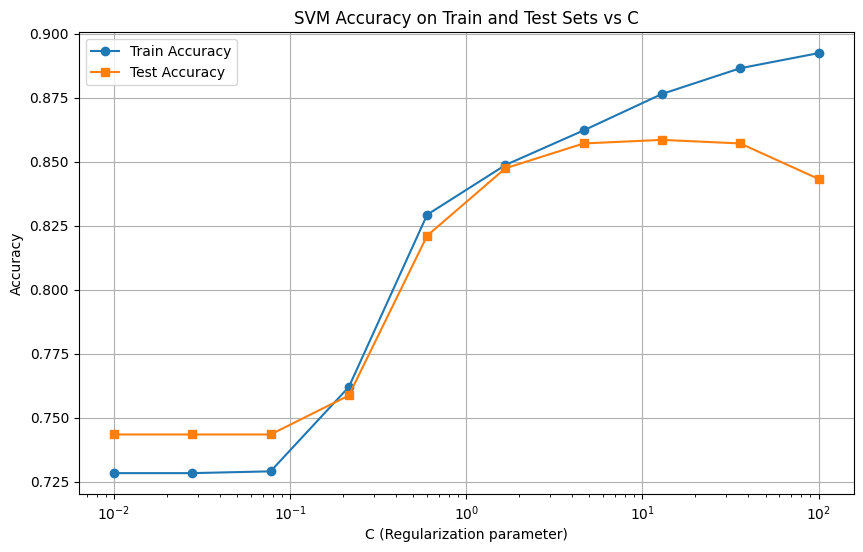

In [ ]:
#@title SVM with Linear kernel (jsut to show a base line )
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a range of C values to try (log scale)
C_values = np.logspace(-2, 2, 10)  # 0.01 to 100

train_accuracies = []
test_accuracies = []

for C in C_values:
    svm = SVC(C=C, kernel='linear')  # using linear kernel, you can try others like 'rbf'
    svm.fit(X_train, y_train)

    y_train_pred = svm.predict(X_train)
    y_test_pred = svm.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(C_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xscale('log')
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy on Train and Test Sets vs C')
plt.legend()
plt.grid(True)
plt.show()


#### Grid Search

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC()

param_grid = {
    'C': [0.01,0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly'],  # Kernel types to try
    'gamma': ['scale', 'auto']  # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
}

grid_search_svm = GridSearchCV(svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)



In [ ]:
grid_search_svm.fit(X_train, y_train)

print(f"Best parameters: {grid_search_svm.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_svm.best_score_:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy: 0.7730


In [ ]:
from sklearn.metrics import classification_report

best_svm = grid_search_svm.best_estimator_

y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)

print("Classification Report - Training Set")
print(classification_report(y_train, y_train_pred))

print("Classification Report - Test Set")
print(classification_report(y_test, y_test_pred))


Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.81      0.70      0.76       783
           1       0.90      0.94      0.92      2099

    accuracy                           0.88      2882
   macro avg       0.85      0.82      0.84      2882
weighted avg       0.87      0.88      0.87      2882

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.75      0.71      0.73       185
           1       0.90      0.92      0.91       536

    accuracy                           0.86       721
   macro avg       0.82      0.81      0.82       721
weighted avg       0.86      0.86      0.86       721



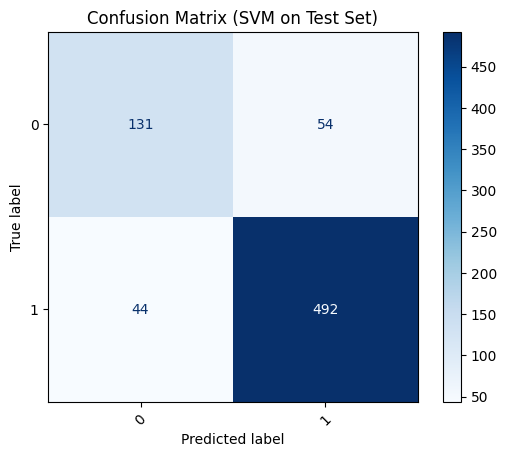

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict using the best model from GridSearch
y_pred = grid_search_svm.best_estimator_.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search_svm.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (SVM on Test Set)")
plt.grid(False)
plt.show()


### Logistic Regression

In [29]:
#@title Logistic Regression with Default Parameters
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Train Accuracy: 0.8203
Test Accuracy: 0.8308


In [31]:
#@title Logistic Regression with Grid Search
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l2'],                   # L2 is commonly used
    'solver': ['liblinear', 'lbfgs'],    # liblinear for small data, lbfgs is default
}

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
Best cross-validation accuracy: 0.8300


In [32]:
#@title Classification Report for Logistic Regression
from sklearn.metrics import classification_report

best_logreg = grid_search.best_estimator_

y_train_pred = best_logreg.predict(X_train)
y_test_pred = best_logreg.predict(X_test)

print("Classification Report - Training Set")
print(classification_report(y_train, y_train_pred))

print("Classification Report - Test Set")
print(classification_report(y_test, y_test_pred))


Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.81      0.72      0.76       783
           1       0.90      0.94      0.92      2099

    accuracy                           0.88      2882
   macro avg       0.86      0.83      0.84      2882
weighted avg       0.88      0.88      0.88      2882

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.72      0.70      0.71       185
           1       0.90      0.90      0.90       536

    accuracy                           0.85       721
   macro avg       0.81      0.80      0.80       721
weighted avg       0.85      0.85      0.85       721



<Figure size 600x600 with 0 Axes>

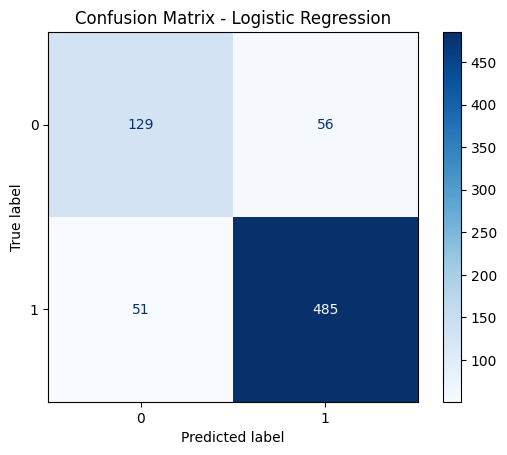

In [33]:
#@title Confusion Matrix for Logistic Regression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test set
y_test_pred = best_logreg.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=best_logreg.classes_)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_logreg.classes_)
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


### Naive Baise

In [35]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize Gaussian Naive Bayes
gnb = GaussianNB()

# Fit the model
gnb.fit(X_train, y_train)

# Predict on train and test
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)

# Print accuracies
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))


Train Accuracy: 0.7557251908396947
Test Accuracy: 0.7753120665742025


In [36]:
print("Classification Report - Training Set")
print(classification_report(y_train, y_train_pred))

print("Classification Report - Test Set")
print(classification_report(y_test, y_test_pred))


Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.56      0.48      0.52       783
           1       0.82      0.86      0.84      2099

    accuracy                           0.76      2882
   macro avg       0.69      0.67      0.68      2882
weighted avg       0.75      0.76      0.75      2882

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.56      0.55      0.55       185
           1       0.85      0.85      0.85       536

    accuracy                           0.78       721
   macro avg       0.70      0.70      0.70       721
weighted avg       0.77      0.78      0.77       721



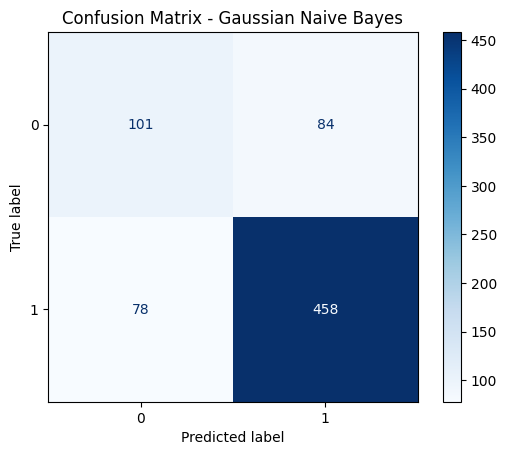

In [37]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()


## E3 Try Embedding Only the Named Entities

In [ ]:
#@title Load the model
from gensim.models import KeyedVectors

# Load the .vec file (pre-trained FastText embeddings in text format)
fasttext_model = KeyedVectors.load_word2vec_format('cc.ar.300.vec', binary=False, encoding='utf-8')


In [38]:
#@title Embedding Using Only Named Entities
import numpy as np
import ast

def embed_named_entities(named_entities_str, model):
    try:
        # Parse string list to Python list
        named_entities = ast.literal_eval(named_entities_str) if named_entities_str else []
    except (ValueError, SyntaxError):
        named_entities = []

    word_vectors = []
    for entity in named_entities:
        if entity in model.key_to_index:
            word_vectors.append(model[entity])
        else:
            word_vectors.append(np.zeros(model.vector_size))

    if word_vectors:
        # Average embeddings of all named entities
        entities_vector = np.mean(word_vectors, axis=0)
    else:
        # If no named entities, zero vector
        entities_vector = np.zeros(model.vector_size)

    return entities_vector

# Apply embedding using only named entities
df['named_entities_embedding'] = df['Named Entities'].apply(lambda x: embed_named_entities(x, fasttext_model))

# Check
print(df['named_entities_embedding'].iloc[0].shape)


(300,)


### split the DF

In [45]:
X = np.vstack(df['named_entities_embedding'].values)
y = df['Label'].values


In [46]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


### KNN

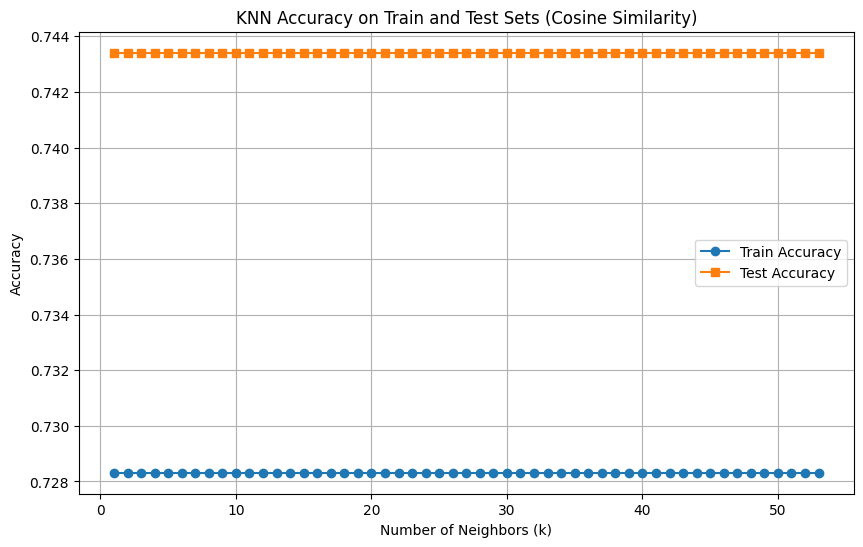

In [47]:
#@title KNN with K from 1 to root of n
# Number of training samples
n_train = X_train.shape[0]

# Maximum k to try: integer part of sqrt(n_train)
max_k = int(sqrt(n_train))

# Store accuracies for train and test
train_accuracies = []
test_accuracies = []

k_values = range(1, max_k + 1)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Predict on train set and test set
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Calculate accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy on Train and Test Sets (Cosine Similarity)')
plt.legend()
plt.grid(True)
plt.show()



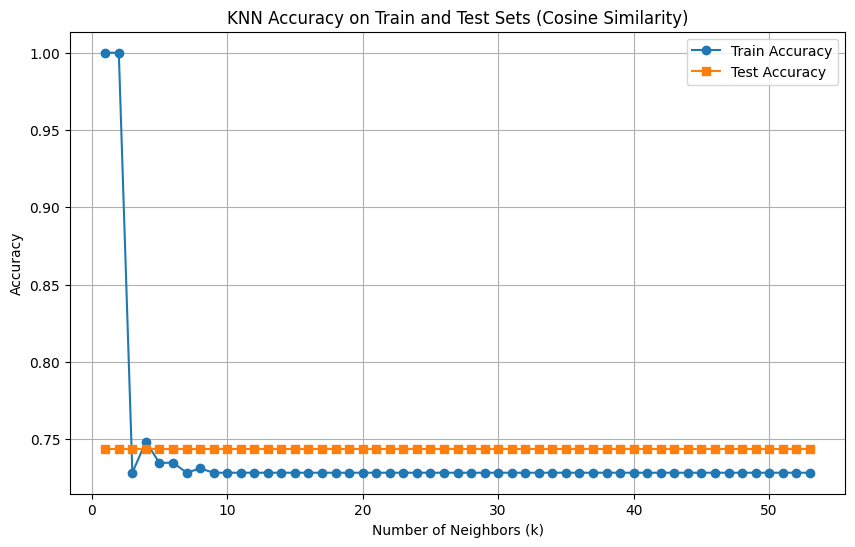

In [48]:
#@title KNN with Cosine Similarity
# Number of training samples
n_train = X_train.shape[0]

# Maximum k to try: integer part of sqrt(n_train)
max_k = int(sqrt(n_train))

# Store accuracies for train and test
train_accuracies = []
test_accuracies = []

k_values = range(1, max_k + 1)

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric='cosine')
    knn.fit(X_train, y_train)

    # Predict on train set and test set
    y_train_pred = knn.predict(X_train)
    y_test_pred = knn.predict(X_test)

    # Calculate accuracy
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(k_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(k_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel('Number of Neighbors (k)')
plt.ylabel('Accuracy')
plt.title('KNN Accuracy on Train and Test Sets (Cosine Similarity)')
plt.legend()
plt.grid(True)
plt.show()


#### Grid Search

In [49]:
#@title KNN with Grid Search   Params
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

knn = KNeighborsClassifier()

param_grid = {
    'n_neighbors': list(range(5, 41)),
    'metric': ['cosine', 'euclidean']  # Add more metrics if you want
}

grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='precision', n_jobs=-1, verbose=2)


In [50]:
#@title Fit the Model
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best parameters: {'metric': 'cosine', 'n_neighbors': 5}
Best cross-validation accuracy: 0.7283


In [51]:
#@title Classfication Report
from sklearn.metrics import classification_report

best_knn = grid_search.best_estimator_

y_train_pred = best_knn.predict(X_train)
y_test_pred = best_knn.predict(X_test)

print("Classification Report - Training Set")
print(classification_report(y_train, y_train_pred))

print("Classification Report - Test Set")
print(classification_report(y_test, y_test_pred))


Classification Report - Training Set
              precision    recall  f1-score   support

           0       1.00      0.02      0.04       783
           1       0.73      1.00      0.85      2099

    accuracy                           0.73      2882
   macro avg       0.87      0.51      0.45      2882
weighted avg       0.81      0.73      0.63      2882

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       185
           1       0.74      1.00      0.85       536

    accuracy                           0.74       721
   macro avg       0.37      0.50      0.43       721
weighted avg       0.55      0.74      0.63       721



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### SVM

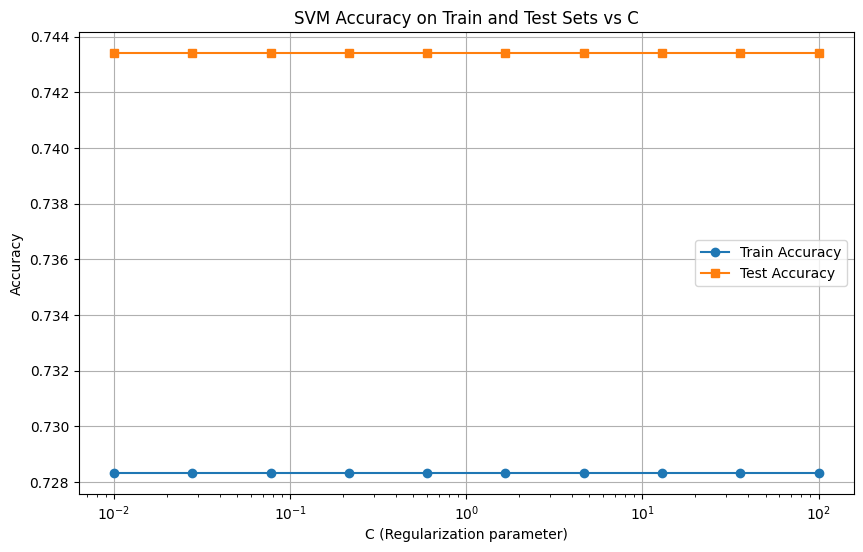

In [52]:
#@title SVM with Linear kernel (jsut to show a base line )
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Define a range of C values to try (log scale)
C_values = np.logspace(-2, 2, 10)  # 0.01 to 100

train_accuracies = []
test_accuracies = []

for C in C_values:
    svm = SVC(C=C, kernel='linear')  # using linear kernel, you can try others like 'rbf'
    svm.fit(X_train, y_train)

    y_train_pred = svm.predict(X_train)
    y_test_pred = svm.predict(X_test)

    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(C_values, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(C_values, test_accuracies, label='Test Accuracy', marker='s')
plt.xscale('log')
plt.xlabel('C (Regularization parameter)')
plt.ylabel('Accuracy')
plt.title('SVM Accuracy on Train and Test Sets vs C')
plt.legend()
plt.grid(True)
plt.show()


#### Grid Search

In [53]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

svm = SVC()

param_grid = {
    'C': [0.01,0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear', 'poly'],  # Kernel types to try
    'gamma': ['scale', 'auto']  # Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
}

grid_search_svm = GridSearchCV(svm, param_grid, cv=5, scoring='f1_macro', n_jobs=-1, verbose=2)



In [54]:
grid_search_svm.fit(X_train, y_train)

print(f"Best parameters: {grid_search_svm.best_params_}")
print(f"Best cross-validation accuracy: {grid_search_svm.best_score_:.4f}")


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best parameters: {'C': 0.01, 'gamma': 'scale', 'kernel': 'linear'}
Best cross-validation accuracy: 0.4214


In [55]:
from sklearn.metrics import classification_report

best_svm = grid_search_svm.best_estimator_

y_train_pred = best_svm.predict(X_train)
y_test_pred = best_svm.predict(X_test)

print("Classification Report - Training Set")
print(classification_report(y_train, y_train_pred))

print("Classification Report - Test Set")
print(classification_report(y_test, y_test_pred))


Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       783
           1       0.73      1.00      0.84      2099

    accuracy                           0.73      2882
   macro avg       0.36      0.50      0.42      2882
weighted avg       0.53      0.73      0.61      2882

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       185
           1       0.74      1.00      0.85       536

    accuracy                           0.74       721
   macro avg       0.37      0.50      0.43       721
weighted avg       0.55      0.74      0.63       721



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

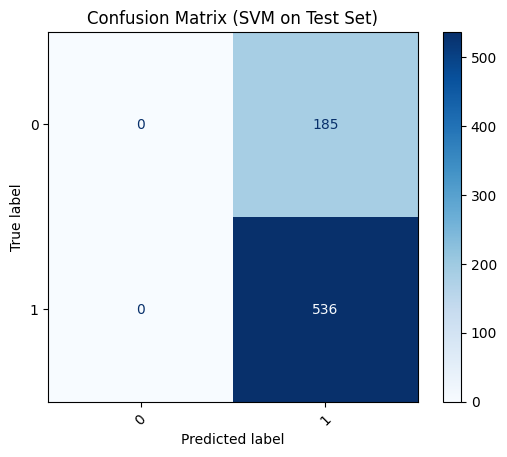

In [56]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict using the best model from GridSearch
y_pred = grid_search_svm.best_estimator_.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid_search_svm.classes_)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix (SVM on Test Set)")
plt.grid(False)
plt.show()


### Logistic Regression

In [64]:
#@title Logistic Regression with Default Parameters
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)

y_train_pred = logreg.predict(X_train)
y_test_pred = logreg.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")


Train Accuracy: 0.7283
Test Accuracy: 0.7434


In [65]:
#@title Logistic Regression with Grid Search
from sklearn.model_selection import GridSearchCV

logreg = LogisticRegression(max_iter=1000)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'penalty': ['l2'],                   # L2 is commonly used
    'solver': ['liblinear', 'lbfgs'],    # liblinear for small data, lbfgs is default
}

grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")


Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
Best cross-validation accuracy: 0.7283


In [66]:
#@title Classification Report for Logistic Regression
from sklearn.metrics import classification_report

best_logreg = grid_search.best_estimator_

y_train_pred = best_logreg.predict(X_train)
y_test_pred = best_logreg.predict(X_test)

print("Classification Report - Training Set")
print(classification_report(y_train, y_train_pred))

print("Classification Report - Test Set")
print(classification_report(y_test, y_test_pred))


Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       783
           1       0.73      1.00      0.84      2099

    accuracy                           0.73      2882
   macro avg       0.36      0.50      0.42      2882
weighted avg       0.53      0.73      0.61      2882

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       185
           1       0.74      1.00      0.85       536

    accuracy                           0.74       721
   macro avg       0.37      0.50      0.43       721
weighted avg       0.55      0.74      0.63       721



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

<Figure size 600x600 with 0 Axes>

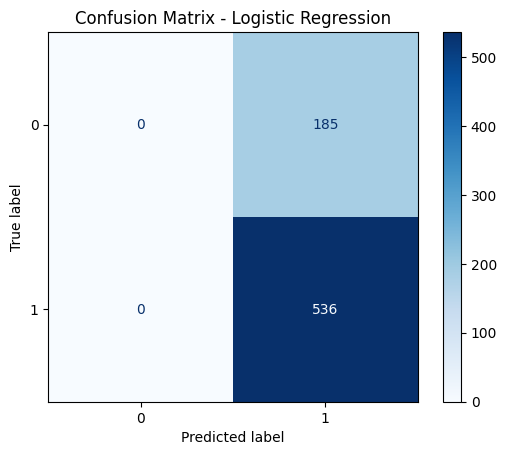

In [67]:
#@title Confusion Matrix for Logistic Regression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Predict on test set
y_test_pred = best_logreg.predict(X_test)

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_test_pred, labels=best_logreg.classes_)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=best_logreg.classes_)
plt.figure(figsize=(6, 6))
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix - Logistic Regression")
plt.show()


### Naive Baise

In [68]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, classification_report

# Initialize Gaussian Naive Bayes
gnb = GaussianNB()

# Fit the model
gnb.fit(X_train, y_train)

# Predict on train and test
y_train_pred = gnb.predict(X_train)
y_test_pred = gnb.predict(X_test)

# Print accuracies
print("Train Accuracy:", accuracy_score(y_train, y_train_pred))
print("Test Accuracy:", accuracy_score(y_test, y_test_pred))


Train Accuracy: 0.27168632893823735
Test Accuracy: 0.2565880721220527


/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:513: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:514: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)
/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:513: RuntimeWarning: divide by zero encountered in log
  n_ij = -0.5 * np.sum(np.log(2.0 * np.pi * self.var_[i, :]))
/usr/local/lib/python3.11/dist-packages/sklearn/naive_bayes.py:514: RuntimeWarning: invalid value encountered in divide
  n_ij -= 0.5 * np.sum(((X - self.theta_[i, :]) ** 2) / (self.var_[i, :]), 1)


In [69]:
print("Classification Report - Training Set")
print(classification_report(y_train, y_train_pred))

print("Classification Report - Test Set")
print(classification_report(y_test, y_test_pred))


Classification Report - Training Set
              precision    recall  f1-score   support

           0       0.27      1.00      0.43       783
           1       0.00      0.00      0.00      2099

    accuracy                           0.27      2882
   macro avg       0.14      0.50      0.21      2882
weighted avg       0.07      0.27      0.12      2882

Classification Report - Test Set
              precision    recall  f1-score   support

           0       0.26      1.00      0.41       185
           1       0.00      0.00      0.00       536

    accuracy                           0.26       721
   macro avg       0.13      0.50      0.20       721
weighted avg       0.07      0.26      0.10       721



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/m

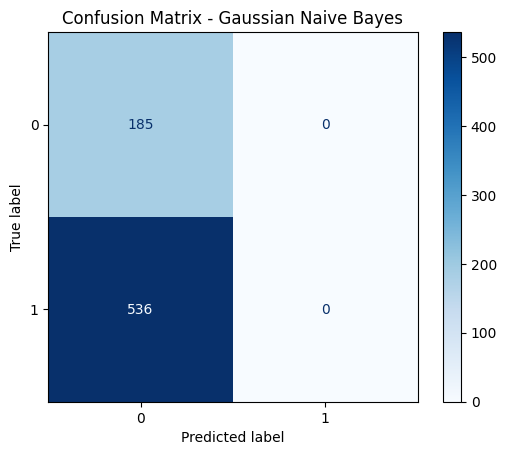

In [70]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_test_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - Gaussian Naive Bayes")
plt.show()


## Conclusion